### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [295]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [296]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [297]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [298]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [299]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [300]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [301]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_133 (Conv2D)          (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 8, 8, 128)         73856     
__________

In [302]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [303]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 6s 4ms/step - loss: 0.0083 - val_loss: 0.0025

Epoch 00001: val_loss improved from inf to 0.00253, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00253 to 0.00187, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 6s 3ms/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss did not improve from 0.00187
Epoch 4/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00187
Epoch 5/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00187
Epoch 6/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0011 - val_loss: 0.0019

Epoc

1712/1712 [==============================] - 6s 4ms/step - loss: 2.1708e-04 - val_loss: 7.9181e-04

Epoch 00046: val_loss did not improve from 0.00076
Epoch 47/150
1712/1712 [==============================] - 7s 4ms/step - loss: 2.1382e-04 - val_loss: 7.8185e-04

Epoch 00047: val_loss did not improve from 0.00076
Epoch 48/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.1256e-04 - val_loss: 8.2077e-04

Epoch 00048: val_loss did not improve from 0.00076
Epoch 49/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.0946e-04 - val_loss: 7.7602e-04

Epoch 00049: val_loss did not improve from 0.00076
Epoch 50/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.0583e-04 - val_loss: 7.8445e-04

Epoch 00050: val_loss did not improve from 0.00076
Epoch 51/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.0328e-04 - val_loss: 7.7420e-04

Epoch 00051: val_loss did not improve from 0.00076
Epoch 52/150
1712/1712 [=====

1712/1712 [==============================] - 6s 3ms/step - loss: 1.3785e-04 - val_loss: 7.5204e-04

Epoch 00095: val_loss did not improve from 0.00073
Epoch 96/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.3832e-04 - val_loss: 7.8002e-04

Epoch 00096: val_loss did not improve from 0.00073
Epoch 97/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.3622e-04 - val_loss: 7.5692e-04

Epoch 00097: val_loss did not improve from 0.00073
Epoch 98/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.2999e-04 - val_loss: 7.4762e-04

Epoch 00098: val_loss did not improve from 0.00073
Epoch 99/150
1712/1712 [==============================] - 7s 4ms/step - loss: 1.2989e-04 - val_loss: 7.3679e-04

Epoch 00099: val_loss did not improve from 0.00073
Epoch 100/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.3015e-04 - val_loss: 7.9819e-04

Epoch 00100: val_loss did not improve from 0.00073
Epoch 101/150
1712/1712 [===

1712/1712 [==============================] - 6s 3ms/step - loss: 9.8236e-05 - val_loss: 7.6109e-04

Epoch 00145: val_loss did not improve from 0.00073
Epoch 146/150
1712/1712 [==============================] - 6s 4ms/step - loss: 9.6526e-05 - val_loss: 7.6166e-04

Epoch 00146: val_loss did not improve from 0.00073
Epoch 147/150
1712/1712 [==============================] - 6s 4ms/step - loss: 9.6360e-05 - val_loss: 7.7026e-04

Epoch 00147: val_loss did not improve from 0.00073
Epoch 148/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.5032e-05 - val_loss: 7.6199e-04

Epoch 00148: val_loss did not improve from 0.00073
Epoch 149/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.6439e-05 - val_loss: 7.8169e-04

Epoch 00149: val_loss did not improve from 0.00073
Epoch 150/150
1712/1712 [==============================] - 6s 4ms/step - loss: 9.5734e-05 - val_loss: 7.6526e-04

Epoch 00150: val_loss did not improve from 0.00073


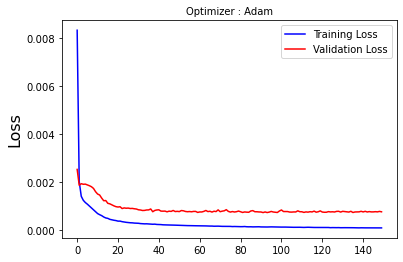

In [304]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [305]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [306]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

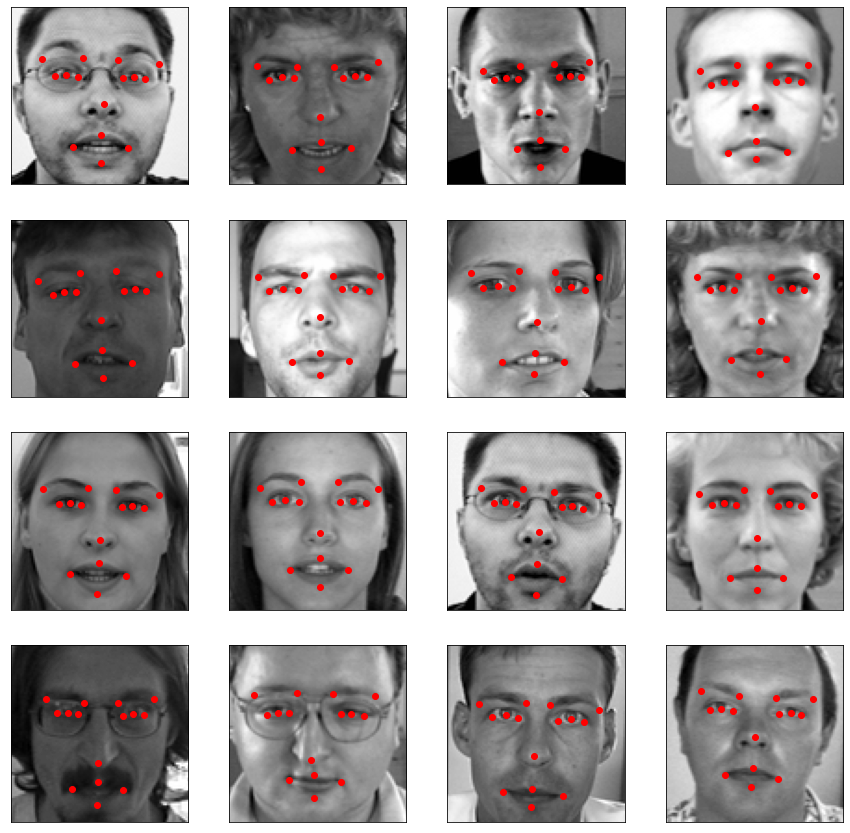

In [307]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [308]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [309]:
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    print(new_img)
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
    
    print(new_img)
    # 翻轉關鍵點 label
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    print(new_points);
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
    print(new_points);   
    return new_img, new_points

In [310]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

[[0.93333334 0.9254902  0.92941177 ... 0.98039216 0.98039216 0.98039216]
 [0.92156863 0.93333334 0.9254902  ... 0.9764706  0.98039216 0.9843137 ]
 [0.92941177 0.9254902  0.92941177 ... 0.9843137  0.9843137  0.98039216]
 ...
 [0.7294118  0.7176471  0.70980394 ... 0.20392157 0.22352941 0.23529412]
 [0.7411765  0.7372549  0.8117647  ... 0.23921569 0.27058825 0.30588236]
 [0.7490196  0.72156864 0.72156864 ... 0.27450982 0.29411766 0.3529412 ]]
[[0.98039216 0.98039216 0.98039216 ... 0.92941177 0.9254902  0.93333334]
 [0.9843137  0.98039216 0.9764706  ... 0.9254902  0.93333334 0.92156863]
 [0.98039216 0.9843137  0.9843137  ... 0.92941177 0.9254902  0.92941177]
 ...
 [0.23529412 0.22352941 0.20392157 ... 0.70980394 0.7176471  0.7294118 ]
 [0.30588236 0.27058825 0.23921569 ... 0.8117647  0.7372549  0.7411765 ]
 [0.3529412  0.29411766 0.27450982 ... 0.72156864 0.72156864 0.7490196 ]]
[-0.18784958 -0.09372631  0.18513533 -0.12060753 -0.12064666 -0.087006
 -0.26177448 -0.08364585  0.12128571 -0.1

[[0.2509804  0.21960784 0.20784314 ... 0.38431373 0.44705883 0.5019608 ]
 [0.24705882 0.20392157 0.20784314 ... 0.4        0.49019608 0.5372549 ]
 [0.20784314 0.19607843 0.20392157 ... 0.41960785 0.5137255  0.63529414]
 ...
 [0.7058824  0.72156864 0.70980394 ... 0.34117648 0.6431373  0.7411765 ]
 [0.7254902  0.72156864 0.72156864 ... 0.4117647  0.6        0.7176471 ]
 [0.70980394 0.64705884 0.4745098  ... 0.36862746 0.6039216  0.73333335]]
[[0.5019608  0.44705883 0.38431373 ... 0.20784314 0.21960784 0.2509804 ]
 [0.5372549  0.49019608 0.4        ... 0.20784314 0.20392157 0.24705882]
 [0.63529414 0.5137255  0.41960785 ... 0.20392157 0.19607843 0.20784314]
 ...
 [0.7411765  0.6431373  0.34117648 ... 0.70980394 0.72156864 0.7058824 ]
 [0.7176471  0.6        0.4117647  ... 0.72156864 0.72156864 0.7254902 ]
 [0.73333335 0.6039216  0.36862746 ... 0.4745098  0.64705884 0.70980394]]
[-0.22118181 -0.08310911  0.23384544 -0.1034182  -0.12773639 -0.08310911
 -0.2943182  -0.07904544  0.1525909  -0

[[0.7647059  0.76862746 0.7647059  ... 0.98039216 0.95686275 0.96862745]
 [0.7607843  0.7647059  0.7607843  ... 0.9764706  0.95686275 0.9647059 ]
 [0.7607843  0.7647059  0.7647059  ... 0.9843137  0.95686275 0.9647059 ]
 ...
 [0.23137255 0.22352941 0.20784314 ... 0.27058825 0.24705882 0.20392157]
 [0.22745098 0.21960784 0.2        ... 0.25490198 0.24705882 0.20392157]
 [0.22745098 0.21960784 0.19215687 ... 0.23529412 0.2509804  0.21960784]]
[-0.19832999 -0.16279149  0.21729499 -0.16279149 -0.12905997 -0.1538535
 -0.2676     -0.14491549  0.15249002 -0.1538535   0.291035   -0.15161899
 -0.10671502 -0.225359   -0.33910495 -0.23206249  0.13014498 -0.234297
  0.35807002 -0.247704    0.00724497  0.05172497 -0.14247     0.27518004
  0.17930499  0.27518004  0.00948     0.24836498  0.01171502  0.371265  ]
[ 0.21729499 -0.16279149 -0.19832999 -0.16279149  0.15249002 -0.1538535
  0.291035   -0.15161899 -0.12905997 -0.1538535  -0.2676     -0.14491549
  0.13014498 -0.234297    0.35807002 -0.247704  

[[0.5058824  0.5058824  0.5019608  ... 0.67058825 0.6745098  0.6784314 ]
 [0.5058824  0.49411765 0.49019608 ... 0.56078434 0.6745098  0.6901961 ]
 [0.49803922 0.49411765 0.49803922 ... 0.30980393 0.59607846 0.7019608 ]
 ...
 [0.58431375 0.5686275  0.5647059  ... 0.54509807 0.5529412  0.56078434]
 [0.5372549  0.5294118  0.5137255  ... 0.5176471  0.5568628  0.5686275 ]
 [0.5058824  0.50980395 0.5058824  ... 0.5058824  0.53333336 0.5647059 ]]
[[0.6784314  0.6745098  0.67058825 ... 0.5019608  0.5058824  0.5058824 ]
 [0.6901961  0.6745098  0.56078434 ... 0.49019608 0.49411765 0.5058824 ]
 [0.7019608  0.59607846 0.30980393 ... 0.49803922 0.49411765 0.49803922]
 ...
 [0.56078434 0.5529412  0.54509807 ... 0.5647059  0.5686275  0.58431375]
 [0.5686275  0.5568628  0.5176471  ... 0.5137255  0.5294118  0.5372549 ]
 [0.5647059  0.53333336 0.5058824  ... 0.5058824  0.50980395 0.5058824 ]]
[-0.20511442 -0.10563853  0.17671686 -0.10293373 -0.1455422  -0.10293373
 -0.26469278 -0.09480724  0.12525904 -0

[[0.42352942 0.5176471  0.60784316 ... 0.6509804  0.654902   0.69411767]
 [0.42352942 0.5176471  0.5882353  ... 0.7019608  0.64705884 0.6784314 ]
 [0.42352942 0.5058824  0.5411765  ... 0.6745098  0.6509804  0.67058825]
 ...
 [0.29411766 0.2901961  0.2901961  ... 0.38039216 0.36862746 0.34509805]
 [0.3137255  0.30980393 0.29411766 ... 0.3764706  0.36862746 0.32941177]
 [0.30588236 0.29411766 0.27450982 ... 0.36862746 0.3764706  0.34901962]]
[[0.69411767 0.654902   0.6509804  ... 0.60784316 0.5176471  0.42352942]
 [0.6784314  0.64705884 0.7019608  ... 0.5882353  0.5176471  0.42352942]
 [0.67058825 0.6509804  0.6745098  ... 0.5411765  0.5058824  0.42352942]
 ...
 [0.34509805 0.36862746 0.38039216 ... 0.2901961  0.2901961  0.29411766]
 [0.32941177 0.36862746 0.3764706  ... 0.29411766 0.30980393 0.3137255 ]
 [0.34901962 0.3764706  0.36862746 ... 0.27450982 0.29411766 0.30588236]]
[-0.18848753 -0.11919376  0.196975   -0.14991876 -0.12145001 -0.1164
 -0.23038125 -0.11081252  0.15786874 -0.141

 [0.14117648 0.13725491 0.14117648 ... 0.14901961 0.16078432 0.14509805]]
[-0.19917434 -0.13282934  0.20263302 -0.13282934 -0.12947708 -0.13692936
 -0.2647798  -0.12462935  0.13292661 -0.13692936  0.2559358  -0.11642936
 -0.11717433 -0.23533121 -0.34267884 -0.2230312   0.11653212 -0.2230312
  0.3584312  -0.19843027  0.00582567 -0.05082569 -0.16637617  0.25667888
  0.1575321   0.26488072  0.00582567  0.16237617  0.00172475  0.33047706]
[ 0.20263302 -0.13282934 -0.19917434 -0.13282934  0.13292661 -0.13692936
  0.2559358  -0.11642936 -0.12947708 -0.13692936 -0.2647798  -0.12462935
  0.11653212 -0.2230312   0.3584312  -0.19843027 -0.11717433 -0.23533121
 -0.34267884 -0.2230312   0.00582567 -0.05082569  0.1575321   0.26488072
 -0.16637617  0.25667888  0.00582567  0.16237617  0.00172475  0.33047706]
[[0.9647059  0.9647059  0.96862745 ... 0.81960785 0.8156863  0.8235294 ]
 [0.9607843  0.972549   0.9607843  ... 0.80784315 0.827451   0.81960785]
 [0.9647059  0.96862745 0.972549   ... 0.80784315

 [0.6        0.5647059  0.5372549  ... 0.43137255 0.5254902  0.5137255 ]]
[-0.17700857 -0.14337608  0.20114529 -0.13573503 -0.11589742 -0.13573503
 -0.2419402  -0.13573503  0.12475213 -0.13191453  0.2508034  -0.12427351
 -0.09086329 -0.21966922 -0.3183419  -0.21976924  0.12093163 -0.20830938
  0.33865812 -0.19685042  0.01779488 -0.04023933 -0.13117093  0.22331625
  0.1362051   0.24241877  0.0063419   0.13164955 -0.00129914  0.2882564 ]
[ 0.20114529 -0.13573503 -0.17700857 -0.14337608  0.12475213 -0.13191453
  0.2508034  -0.12427351 -0.11589742 -0.13573503 -0.2419402  -0.13573503
  0.12093163 -0.20830938  0.33865812 -0.19685042 -0.09086329 -0.21966922
 -0.3183419  -0.21976924  0.01779488 -0.04023933  0.1362051   0.24241877
 -0.13117093  0.22331625  0.0063419   0.13164955 -0.00129914  0.2882564 ]
[[0.6901961  0.7019608  0.7058824  ... 0.9882353  0.99607843 0.99607843]
 [0.69411767 0.7058824  0.7019608  ... 0.9764706  1.         0.99607843]
 [0.69411767 0.69803923 0.7058824  ... 0.9686274

 [0.5803922  0.5568628  0.56078434 ... 0.6313726  0.6627451  0.6509804 ]]
[-0.21677184 -0.09375635  0.18214095 -0.117751   -0.15378523 -0.09675571
 -0.31575173 -0.07276037  0.11915436 -0.12075034  0.27512753 -0.10575369
 -0.11779195 -0.25572282 -0.36074495 -0.18673691  0.08016777 -0.2647208
  0.3321141  -0.2197302   0.02317449  0.12520134 -0.20177847  0.2511745
  0.19114092  0.2031812   0.00818121  0.19718122  0.0201745   0.3291543 ]
[ 0.18214095 -0.117751   -0.21677184 -0.09375635  0.11915436 -0.12075034
  0.27512753 -0.10575369 -0.15378523 -0.09675571 -0.31575173 -0.07276037
  0.08016777 -0.2647208   0.3321141  -0.2197302  -0.11779195 -0.25572282
 -0.36074495 -0.18673691  0.02317449  0.12520134  0.19114092  0.2031812
 -0.20177847  0.2511745   0.00818121  0.19718122  0.0201745   0.3291543 ]
[[0.7058824  0.7137255  0.7058824  ... 0.7176471  0.7176471  0.7176471 ]
 [0.7137255  0.7058824  0.7137255  ... 0.70980394 0.7137255  0.7137255 ]
 [0.70980394 0.70980394 0.70980394 ... 0.7137255  0

[[0.6        0.5882353  0.5921569  ... 0.81960785 0.8156863  0.8117647 ]
 [0.6        0.6        0.60784316 ... 0.8156863  0.8156863  0.8117647 ]
 [0.6039216  0.6156863  0.654902   ... 0.80784315 0.8117647  0.8117647 ]
 ...
 [0.57254905 0.5764706  0.5764706  ... 0.53333336 0.6117647  0.70980394]
 [0.58431375 0.5803922  0.5921569  ... 0.6627451  0.6117647  0.6       ]
 [0.5921569  0.58431375 0.59607846 ... 0.62352943 0.654902   0.6117647 ]]
[-0.18187922 -0.1035839   0.18704697 -0.10058391 -0.13688594 -0.1035839
 -0.25985909 -0.09158388  0.13306043 -0.10958388  0.24103355 -0.0945839
 -0.08289933 -0.2205604  -0.31085235 -0.19956443  0.09706712 -0.2205604
  0.31114763 -0.19171813  0.01608053  0.12136912 -0.13688594  0.24434227
  0.13605368  0.22934896  0.00108722  0.16336244  0.00108722  0.32832885]
[ 0.18704697 -0.10058391 -0.18187922 -0.1035839   0.13306043 -0.10958388
  0.24103355 -0.0945839  -0.13688594 -0.1035839  -0.25985909 -0.09158388
  0.09706712 -0.2205604   0.31114763 -0.1917181

[[0.49019608 0.49019608 0.49411765 ... 0.25882354 0.40392157 0.5529412 ]
 [0.49411765 0.48235294 0.49411765 ... 0.24705882 0.3254902  0.48235294]
 [0.49411765 0.49411765 0.5019608  ... 0.23137255 0.29411766 0.40392157]
 ...
 [0.49803922 0.5058824  0.50980395 ... 0.19607843 0.21960784 0.27450982]
 [0.5019608  0.5058824  0.5058824  ... 0.18431373 0.23137255 0.2784314 ]
 [0.49803922 0.5019608  0.5058824  ... 0.18431373 0.22352941 0.29411766]]
[[0.5529412  0.40392157 0.25882354 ... 0.49411765 0.49019608 0.49019608]
 [0.48235294 0.3254902  0.24705882 ... 0.49411765 0.48235294 0.49411765]
 [0.40392157 0.29411766 0.23137255 ... 0.5019608  0.49411765 0.49411765]
 ...
 [0.27450982 0.21960784 0.19607843 ... 0.50980395 0.5058824  0.49803922]
 [0.2784314  0.23137255 0.18431373 ... 0.5058824  0.5058824  0.5019608 ]
 [0.29411766 0.22352941 0.18431373 ... 0.5058824  0.5019608  0.49803922]]
[-0.21501637 -0.10924998  0.17327869 -0.11291313 -0.1416803  -0.10315165
 -0.28095907 -0.10558689  0.11466393 -0

[[0.99215686 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.99607843]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.99607843]
 [0.99215686 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.99607843]
 ...
 [0.42745098 0.34509805 0.34117648 ... 0.17254902 0.18431373 0.18431373]
 [0.3529412  0.2784314  0.2784314  ... 0.18039216 0.1764706  0.16078432]
 [0.34509805 0.23529412 0.23137255 ... 0.15686275 0.18039216 0.14901961]]
[-0.1636377  -0.11691013  0.16668114 -0.10719493 -0.11182612 -0.11043334
 -0.21679711 -0.11973333  0.11163044 -0.10071811  0.21849999 -0.10071811
 -0.09239131 -0.17196378 -0.27050728 -0.18491814  0.07276812 -0.16872537
  0.280029   -0.16872537 -0.01467389  0.10006666 -0.13449275  0.24903625
  0.12134781  0.24903625 -0.00775361  0.21484059 -0.0076232   0.30713767]
[ 0.16668114 -0.10719493 -0.1636377  -0.11691013  0.11163044 -0.10071811
  0.21849999 -0.10071811 -0.11182612 -0.11043334 -0.21679711 -0.11973333
  0.07276812 -0.16872537  0.280029   -0.1687

[[0.3764706  0.36078432 0.30980393 ... 0.4117647  0.4392157  0.4745098 ]
 [0.34901962 0.30980393 0.29411766 ... 0.34901962 0.39607844 0.41568628]
 [0.30980393 0.2784314  0.2509804  ... 0.26666668 0.29803923 0.34117648]
 ...
 [0.03529412 0.01960784 0.00392157 ... 0.15686275 0.16470589 0.17254902]
 [0.00784314 0.02745098 0.07450981 ... 0.16862746 0.19215687 0.20784314]
 [0.02352941 0.03529412 0.08235294 ... 0.19607843 0.23921569 0.2901961 ]]
[-0.16866904 -0.13204822  0.1978561  -0.09668127 -0.10115105 -0.12561798
 -0.22653955 -0.13526332  0.1303381  -0.10632733  0.24930215 -0.08382085
 -0.08186334 -0.21885756 -0.2844172  -0.21564245  0.11748204 -0.18027553
  0.31055397 -0.17247698  0.0113813  -0.01630214 -0.15581292  0.2312662
  0.12712228  0.2666331  -0.00469786  0.16053236 -0.01434535  0.3148561 ]
[ 0.1978561  -0.09668127 -0.16866904 -0.13204822  0.1303381  -0.10632733
  0.24930215 -0.08382085 -0.10115105 -0.12561798 -0.22653955 -0.13526332
  0.11748204 -0.18027553  0.31055397 -0.17247

[[0.972549   0.972549   0.972549   ... 0.73333335 0.72156864 0.7254902 ]
 [0.972549   0.972549   0.972549   ... 0.7294118  0.72156864 0.7254902 ]
 [0.972549   0.972549   0.972549   ... 0.7294118  0.72156864 0.7137255 ]
 ...
 [0.2784314  0.29411766 0.30588236 ... 0.18431373 0.19607843 0.2       ]
 [0.24313726 0.2        0.25882354 ... 0.21568628 0.20392157 0.20784314]
 [0.21960784 0.15294118 0.25490198 ... 0.27058825 0.23529412 0.22352941]]
[-0.19595212 -0.11406589  0.20010778 -0.12209582 -0.12637126 -0.10871258
 -0.25214964 -0.10603595  0.12785628 -0.11138925  0.2563054  -0.11941919
 -0.12102395 -0.17561677 -0.31370062 -0.21040538  0.10377243 -0.19167066
  0.30447906 -0.22646168 -0.00862277  0.04917365 -0.1344012   0.26326346
  0.1465868   0.25255686 -0.00327545  0.20974255 -0.00204194  0.30886823]
[ 0.20010778 -0.12209582 -0.19595212 -0.11406589  0.12785628 -0.11138925
  0.2563054  -0.11941919 -0.12637126 -0.10871258 -0.25214964 -0.10603595
  0.10377243 -0.19167066  0.30447906 -0.2264

[[0.5372549  0.52156866 0.47058824 ... 0.99607843 0.99607843 0.99607843]
 [0.5137255  0.50980395 0.49019608 ... 0.99607843 0.99607843 0.99607843]
 [0.5019608  0.4745098  0.47058824 ... 0.99607843 0.99607843 0.99607843]
 ...
 [0.10980392 0.10588235 0.09803922 ... 0.14509805 0.15686275 0.18431373]
 [0.1254902  0.13333334 0.11764706 ... 0.1254902  0.13725491 0.16078432]
 [0.12156863 0.1254902  0.11372549 ... 0.11764706 0.11372549 0.1254902 ]]
[-0.17927909 -0.11257985  0.15676746 -0.12297288 -0.1273101  -0.10911474
 -0.24510074 -0.10911474  0.09787595 -0.11257985  0.22952715 -0.11604419
 -0.07187599 -0.19226047 -0.31092244 -0.15761706  0.04590699 -0.19918916
  0.2752248  -0.18845117 -0.0095194   0.06410855 -0.10998446  0.29275197
  0.12558913  0.28582948  0.00779843  0.20961237  0.01126358  0.40362018]
[ 0.15676746 -0.12297288 -0.17927909 -0.11257985  0.09787595 -0.11257985
  0.22952715 -0.11604419 -0.1273101  -0.10911474 -0.24510074 -0.10911474
  0.04590699 -0.19918916  0.2752248  -0.1884

[[0.42745098 0.43137255 0.40784314 ... 0.6862745  0.6784314  0.68235296]
 [0.42745098 0.43137255 0.40784314 ... 0.6784314  0.68235296 0.6901961 ]
 [0.43137255 0.43137255 0.41568628 ... 0.68235296 0.68235296 0.6862745 ]
 ...
 [0.29411766 0.30980393 0.3254902  ... 0.38431373 0.38431373 0.37254903]
 [0.32156864 0.3254902  0.3254902  ... 0.3764706  0.38039216 0.38431373]
 [0.32156864 0.32941177 0.34509805 ... 0.38039216 0.39215687 0.39607844]]
[[0.68235296 0.6784314  0.6862745  ... 0.40784314 0.43137255 0.42745098]
 [0.6901961  0.68235296 0.6784314  ... 0.40784314 0.43137255 0.42745098]
 [0.6862745  0.68235296 0.68235296 ... 0.41568628 0.43137255 0.43137255]
 ...
 [0.37254903 0.38431373 0.38431373 ... 0.3254902  0.30980393 0.29411766]
 [0.38431373 0.38039216 0.3764706  ... 0.3254902  0.3254902  0.32156864]
 [0.39607844 0.39215687 0.38039216 ... 0.34509805 0.32941177 0.32156864]]
[-0.1657517  -0.13170469  0.17617449 -0.14070472 -0.10276508 -0.12271142
 -0.21374494 -0.1287047   0.12818792 -0

[[0.9529412  0.84705883 0.65882355 ... 0.99607843 0.99607843 0.99607843]
 [0.9098039  0.7490196  0.57254905 ... 0.99607843 0.99607843 0.99607843]
 [0.85490197 0.6745098  0.52156866 ... 0.99607843 0.99607843 0.99607843]
 ...
 [0.34117648 0.3764706  0.29411766 ... 0.15686275 0.13333334 0.15294118]
 [0.35686275 0.4509804  0.4627451  ... 0.1764706  0.16078432 0.16078432]
 [0.35686275 0.45882353 0.5372549  ... 0.12941177 0.14509805 0.15686275]]
[-0.21247655 -0.14533362  0.14364842 -0.13136795 -0.145625   -0.13502344
 -0.27232033 -0.15151095  0.08778906 -0.11041877  0.2065     -0.12438437
 -0.1412422  -0.24102733 -0.3486485  -0.2221461   0.06335154 -0.20468828
  0.26934373 -0.19770548 -0.02044529  0.09906954 -0.21247655  0.25269532
  0.11921093  0.25967973 -0.04210156  0.22596097 -0.04695314  0.3256328 ]
[ 0.14364842 -0.13136795 -0.21247655 -0.14533362  0.08778906 -0.11041877
  0.2065     -0.12438437 -0.145625   -0.13502344 -0.27232033 -0.15151095
  0.06335154 -0.20468828  0.26934373 -0.1977

[[0.6784314  0.6784314  0.6745098  ... 0.69411767 0.6901961  0.68235296]
 [0.6784314  0.6784314  0.6784314  ... 0.69411767 0.6901961  0.6901961 ]
 [0.6862745  0.6862745  0.6784314  ... 0.69803923 0.69411767 0.69411767]
 ...
 [0.56078434 0.5568628  0.5686275  ... 0.5803922  0.58431375 0.5764706 ]
 [0.56078434 0.56078434 0.5647059  ... 0.5764706  0.5803922  0.5764706 ]
 [0.56078434 0.5568628  0.5647059  ... 0.5764706  0.5764706  0.5647059 ]]
[-0.17633796 -0.09774482  0.19659999 -0.08233103 -0.08079308 -0.07924828
 -0.25646895 -0.07616553  0.12571034 -0.07000688  0.27673793 -0.06075862
 -0.06537932 -0.17787585 -0.29037243 -0.17787585  0.13804138 -0.18712413
  0.33837932 -0.13780689  0.03016552  0.04711723 -0.15784138  0.31526208
  0.16577932  0.33066893  0.02091727  0.24128962  0.01783445  0.37382072]
[ 0.19659999 -0.08233103 -0.17633796 -0.09774482  0.12571034 -0.07000688
  0.27673793 -0.06075862 -0.08079308 -0.07924828 -0.25646895 -0.07616553
  0.13804138 -0.18712413  0.33837932 -0.1378

[[0.80784315 0.8156863  0.8235294  ... 0.8745098  0.87058824 0.87058824]
 [0.80784315 0.8117647  0.8156863  ... 0.88235295 0.8627451  0.8627451 ]
 [0.80784315 0.8039216  0.8156863  ... 0.8745098  0.87058824 0.85882354]
 ...
 [0.5372549  0.54509807 0.54509807 ... 0.6039216  0.60784316 0.60784316]
 [0.54509807 0.5411765  0.54901963 ... 0.5882353  0.6        0.60784316]
 [0.5411765  0.5411765  0.5411765  ... 0.6039216  0.60784316 0.6       ]]
[[0.87058824 0.87058824 0.8745098  ... 0.8235294  0.8156863  0.80784315]
 [0.8627451  0.8627451  0.88235295 ... 0.8156863  0.8117647  0.80784315]
 [0.85882354 0.87058824 0.8745098  ... 0.8156863  0.8039216  0.80784315]
 ...
 [0.60784316 0.60784316 0.6039216  ... 0.54509807 0.54509807 0.5372549 ]
 [0.60784316 0.6        0.5882353  ... 0.54901963 0.5411765  0.54509807]
 [0.6        0.60784316 0.6039216  ... 0.5411765  0.5411765  0.5411765 ]]
[-0.20727086 -0.10220137  0.16515279 -0.11461806 -0.1545139  -0.10220137
 -0.26934028 -0.09288886  0.10308334 -0

 [0.         0.         0.00784314 ... 0.33333334 0.34901962 0.34509805]]
[-0.19264483 -0.12381777  0.17908409 -0.12381777 -0.14252335 -0.11128783
 -0.2552991  -0.1196411   0.1206075  -0.11546448  0.23755142 -0.11546448
 -0.09814018 -0.20669532 -0.33465415 -0.18229252  0.06213084 -0.19899908
  0.29915887 -0.2061243  -0.0046916   0.03071964 -0.15923363  0.28549534
  0.11225235  0.28549534 -0.00886917  0.19778508 -0.01722431  0.37738317]
[ 0.17908409 -0.12381777 -0.19264483 -0.12381777  0.1206075  -0.11546448
  0.23755142 -0.11546448 -0.14252335 -0.11128783 -0.2552991  -0.1196411
  0.06213084 -0.19899908  0.29915887 -0.2061243  -0.09814018 -0.20669532
 -0.33465415 -0.18229252 -0.0046916   0.03071964  0.11225235  0.28549534
 -0.15923363  0.28549534 -0.00886917  0.19778508 -0.01722431  0.37738317]
[[0.41960785 0.3882353  0.4509804  ... 0.45882353 0.41568628 0.38039216]
 [0.41568628 0.42745098 0.41960785 ... 0.4627451  0.44705883 0.40392157]
 [0.42745098 0.40392157 0.3254902  ... 0.4509804 

[[0.7882353  0.78431374 0.79607844 ... 0.72156864 0.7294118  0.7019608 ]
 [0.79607844 0.7921569  0.79607844 ... 0.7137255  0.7019608  0.6862745 ]
 [0.8039216  0.8039216  0.8039216  ... 0.7058824  0.7019608  0.6901961 ]
 ...
 [0.60784316 0.6117647  0.62352943 ... 0.2627451  0.26666668 0.27450982]
 [0.6117647  0.6156863  0.61960787 ... 0.25882354 0.28235295 0.2784314 ]
 [0.6039216  0.6039216  0.6156863  ... 0.2627451  0.26666668 0.2784314 ]]
[-0.20146626 -0.10180473  0.17901352 -0.10784391 -0.12899321 -0.09576556
 -0.2527973  -0.08972636  0.1125811  -0.09878513  0.25147974 -0.09274593
 -0.09879726 -0.20145339 -0.33735132 -0.15615809  0.08539864 -0.17729595
  0.33301353 -0.15615809  0.0004189   0.08758783 -0.13805407  0.31188512
  0.16089189  0.3058446   0.00223649  0.2750743   0.00085136  0.35416216]
[ 0.17901352 -0.10784391 -0.20146626 -0.10180473  0.1125811  -0.09878513
  0.25147974 -0.09274593 -0.12899321 -0.09576556 -0.2527973  -0.08972636
  0.08539864 -0.17729595  0.33301353 -0.1561

[[0.72156864 0.7137255  0.7137255  ... 0.7882353  0.7882353  0.7882353 ]
 [0.72156864 0.72156864 0.7137255  ... 0.7882353  0.7882353  0.7882353 ]
 [0.70980394 0.7137255  0.7058824  ... 0.78431374 0.7882353  0.7882353 ]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]]
[-0.19513041 -0.13152972  0.17081884 -0.11857608 -0.13683337 -0.12181449
 -0.25665945 -0.13476813  0.10281157 -0.10886085  0.24206522 -0.11857608
 -0.12712318 -0.17686811 -0.30523914 -0.20601448  0.09957245 -0.16391447
  0.27768838 -0.16067609 -0.01053625  0.12107247 -0.18865222  0.25060868
  0.13195655  0.25060868 -0.0170145   0.25060868 -0.01377535  0.33481163]
[ 0.17081884 -0.11857608 -0.19513041 -0.13152972  0.10281157 -0.10886085
  0.24206522 -0.11857608 -0.13683337 -0.12181449 -0.25665945 -0.13476813
  0.09957245 -0.16391447  0.27768838 -0.1606

[[0.4        0.3137255  0.29411766 ... 0.16470589 0.18039216 0.16862746]
 [0.36078432 0.34117648 0.31764707 ... 0.12941177 0.13725491 0.14509805]
 [0.3882353  0.3529412  0.2784314  ... 0.13333334 0.1254902  0.12941177]
 ...
 [0.2784314  0.24313726 0.20784314 ... 0.22745098 0.25490198 0.2784314 ]
 [0.31764707 0.25882354 0.22352941 ... 0.25490198 0.25490198 0.25882354]
 [0.27450982 0.25490198 0.23529412 ... 0.27450982 0.27450982 0.26666668]]
[-0.18414658 -0.14159742  0.19726723 -0.13389227 -0.11479312 -0.13389227
 -0.23807758 -0.13389227  0.1356293  -0.13389227  0.25506032 -0.1146293
 -0.10323274 -0.22250345 -0.31128448 -0.21479827  0.11636207 -0.20323965
  0.3359655  -0.18012413  0.02005172 -0.0375776  -0.1725862   0.23596549
  0.1703017   0.25137067  0.0084914   0.16661209 -0.00306898  0.2783448 ]
[ 0.19726723 -0.13389227 -0.18414658 -0.14159742  0.1356293  -0.13389227
  0.25506032 -0.1146293  -0.11479312 -0.13389227 -0.23807758 -0.13389227
  0.11636207 -0.20323965  0.3359655  -0.18012

[[0.972549   0.972549   0.972549   ... 0.84313726 0.84705883 0.8392157 ]
 [0.972549   0.972549   0.972549   ... 0.84705883 0.84705883 0.84705883]
 [0.972549   0.972549   0.972549   ... 0.84313726 0.84705883 0.84313726]
 ...
 [0.21960784 0.19607843 0.19607843 ... 0.33333334 0.45490196 0.56078434]
 [0.20784314 0.1882353  0.19215687 ... 0.23137255 0.34901962 0.47843137]
 [0.18431373 0.1882353  0.21176471 ... 0.1764706  0.28235295 0.39215687]]
[-0.19960624 -0.10116252  0.18585    -0.1263     -0.1353625  -0.09278128
 -0.26105624 -0.08720002  0.116025   -0.10954377  0.25009376 -0.11792502
 -0.14933127 -0.16819999 -0.3169188  -0.19054374  0.10485002 -0.19054374
  0.29199374 -0.2324425  -0.02922499  0.0776     -0.12977499  0.26474375
  0.16909376  0.24518752  0.00429377  0.2228437   0.00988126  0.34015626]
[ 0.18585    -0.1263     -0.19960624 -0.10116252  0.116025   -0.10954377
  0.25009376 -0.11792502 -0.1353625  -0.09278128 -0.26105624 -0.08720002
  0.10485002 -0.19054374  0.29199374 -0.2324

[-0.16194195 -0.11890066  0.20058063 -0.11020002 -0.09523875 -0.11310002
 -0.21994835 -0.11020002  0.13678065 -0.11310002  0.26438707 -0.10439935
 -0.05173546 -0.2204071  -0.31036776 -0.18249097  0.10545161 -0.22029549
  0.36239356 -0.19087678  0.03527096  0.04061031 -0.16483873  0.26682585
  0.18028387  0.2755291   0.01787099  0.20881939  0.01496777  0.35092902]
[ 0.20058063 -0.11020002 -0.16194195 -0.11890066  0.13678065 -0.11310002
  0.26438707 -0.10439935 -0.09523875 -0.11310002 -0.21994835 -0.11020002
  0.10545161 -0.22029549  0.36239356 -0.19087678 -0.05173546 -0.2204071
 -0.31036776 -0.18249097  0.03527096  0.04061031  0.18028387  0.2755291
 -0.16483873  0.26682585  0.01787099  0.20881939  0.01496777  0.35092902]
[[0.5372549  0.61960787 0.69803923 ... 0.78039217 0.78431374 0.7882353 ]
 [0.54901963 0.62352943 0.69411767 ... 0.78039217 0.78039217 0.7921569 ]
 [0.54509807 0.627451   0.69803923 ... 0.7882353  0.7882353  0.78431374]
 ...
 [0.2627451  0.27058825 0.27058825 ... 0.30588

[[0.19215687 0.14901961 0.13725491 ... 0.1764706  0.20784314 0.2627451 ]
 [0.19607843 0.16078432 0.14901961 ... 0.18431373 0.19607843 0.23921569]
 [0.1882353  0.16078432 0.13725491 ... 0.1882353  0.20392157 0.22352941]
 ...
 [0.60784316 0.6        0.60784316 ... 0.31764707 0.15686275 0.38039216]
 [0.6        0.6039216  0.60784316 ... 0.3019608  0.17254902 0.4       ]
 [0.6039216  0.6        0.6039216  ... 0.3019608  0.18431373 0.43137255]]
[[0.2627451  0.20784314 0.1764706  ... 0.13725491 0.14901961 0.19215687]
 [0.23921569 0.19607843 0.18431373 ... 0.14901961 0.16078432 0.19607843]
 [0.22352941 0.20392157 0.1882353  ... 0.13725491 0.16078432 0.1882353 ]
 ...
 [0.38039216 0.15686275 0.31764707 ... 0.60784316 0.6        0.60784316]
 [0.4        0.17254902 0.3019608  ... 0.60784316 0.6039216  0.6       ]
 [0.43137255 0.18431373 0.3019608  ... 0.6039216  0.6        0.6039216 ]]
[-0.20980161 -0.13239601  0.20048413 -0.11812541 -0.12774605 -0.12169287
 -0.27402377 -0.1252611   0.129127   -0

[[0.13725491 0.14509805 0.14117648 ... 0.27058825 0.24313726 0.23921569]
 [0.14117648 0.15294118 0.15294118 ... 0.2627451  0.2509804  0.24705882]
 [0.12156863 0.14117648 0.14509805 ... 0.24313726 0.22745098 0.23137255]
 ...
 [0.13725491 0.13725491 0.13725491 ... 0.15686275 0.15686275 0.16470589]
 [0.13725491 0.13333334 0.14901961 ... 0.17254902 0.17254902 0.17254902]
 [0.1882353  0.17254902 0.17254902 ... 0.19215687 0.19215687 0.1882353 ]]
[[0.23921569 0.24313726 0.27058825 ... 0.14117648 0.14509805 0.13725491]
 [0.24705882 0.2509804  0.2627451  ... 0.15294118 0.15294118 0.14117648]
 [0.23137255 0.22745098 0.24313726 ... 0.14509805 0.14117648 0.12156863]
 ...
 [0.16470589 0.15686275 0.15686275 ... 0.13725491 0.13725491 0.13725491]
 [0.17254902 0.17254902 0.17254902 ... 0.14901961 0.13333334 0.13725491]
 [0.1882353  0.19215687 0.19215687 ... 0.17254902 0.17254902 0.1882353 ]]
[-0.18875456 -0.15648183  0.20533636 -0.13210455 -0.11562729 -0.14429271
 -0.2456364  -0.14429271  0.13626364 -0

[[0.60784316 0.5882353  0.5686275  ... 0.6431373  0.654902   0.6666667 ]
 [0.60784316 0.5921569  0.5568628  ... 0.64705884 0.6509804  0.654902  ]
 [0.60784316 0.58431375 0.5529412  ... 0.6509804  0.654902   0.65882355]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.10980392 0.10980392 0.09019608]
 [0.00392157 0.00392157 0.00392157 ... 0.11372549 0.11372549 0.08627451]
 [0.00392157 0.00392157 0.00392157 ... 0.09411765 0.09803922 0.10196079]]
[-0.2214868  -0.12206385  0.1754342  -0.11618355 -0.13622367 -0.11324343
 -0.28028947 -0.10442236  0.11957237 -0.11324343  0.25776315 -0.09266186
 -0.08330262 -0.23967105 -0.3390987  -0.20144868  0.06959212 -0.23967105
  0.32244736 -0.1926283   0.0137237   0.06023026 -0.14798683  0.29250002
  0.16955262  0.29250002  0.0313684   0.20135528  0.02548683  0.4042303 ]
[ 0.1754342  -0.11618355 -0.2214868  -0.12206385  0.11957237 -0.11324343
  0.25776315 -0.09266186 -0.13622367 -0.11324343 -0.28028947 -0.10442236
  0.06959212 -0.23967105  0.32244736 -0.1926

[[0.49019608 0.49411765 0.5058824  ... 0.3529412  0.5176471  0.48235294]
 [0.5058824  0.5019608  0.5058824  ... 0.3372549  0.5254902  0.4862745 ]
 [0.49019608 0.4862745  0.49411765 ... 0.2784314  0.4745098  0.4862745 ]
 ...
 [0.60784316 0.6039216  0.60784316 ... 0.4862745  0.4862745  0.4862745 ]
 [0.61960787 0.62352943 0.61960787 ... 0.49411765 0.49803922 0.5019608 ]
 [0.627451   0.6509804  0.6509804  ... 0.5294118  0.5019608  0.5019608 ]]
[-0.1863696  -0.08492029  0.2012681  -0.09795654 -0.1114493  -0.07515216
 -0.24500728 -0.07515216  0.13937679 -0.08492029  0.2859565  -0.08818117
 -0.11471015 -0.18264782 -0.3297029  -0.16961595  0.13286233 -0.19893551
  0.35436958 -0.1793913  -0.00334054  0.15736955 -0.12773913  0.38415217
  0.14263043  0.3971812   0.00255796  0.33854347  0.00255796  0.4688478 ]
[ 0.2012681  -0.09795654 -0.1863696  -0.08492029  0.13937679 -0.08492029
  0.2859565  -0.08818117 -0.1114493  -0.07515216 -0.24500728 -0.07515216
  0.13286233 -0.19893551  0.35436958 -0.1793

[[0.6509804  0.6313726  0.654902   ... 0.88235295 0.8901961  0.89411765]
 [0.64705884 0.627451   0.6509804  ... 0.8745098  0.8862745  0.89411765]
 [0.6509804  0.627451   0.654902   ... 0.8745098  0.8901961  0.8862745 ]
 ...
 [0.34117648 0.34117648 0.40784314 ... 0.36862746 0.36862746 0.36862746]
 [0.3254902  0.33333334 0.39607844 ... 0.38039216 0.36862746 0.38039216]
 [0.3137255  0.30980393 0.36078432 ... 0.3764706  0.38431373 0.3882353 ]]
[-0.17902535 -0.10933545  0.1801962  -0.08953166 -0.11679751 -0.08953166
 -0.24974054 -0.10650635  0.10948732 -0.0753924   0.25939876 -0.0753924
 -0.1117152  -0.18593988 -0.30913925 -0.177219    0.10382912 -0.177219
  0.32445568 -0.1404481  -0.03194302  0.09714556 -0.19034177  0.24706334
  0.14343038  0.2612025  -0.02628481  0.23291773 -0.02911395  0.32908863]
[ 0.1801962  -0.08953166 -0.17902535 -0.10933545  0.10948732 -0.0753924
  0.25939876 -0.0753924  -0.11679751 -0.08953166 -0.24974054 -0.10650635
  0.10382912 -0.177219    0.32445568 -0.1404481 

[[0.627451   0.6313726  0.64705884 ... 0.62352943 0.61960787 0.6117647 ]
 [0.6392157  0.61960787 0.60784316 ... 0.6313726  0.60784316 0.6117647 ]
 [0.627451   0.6117647  0.57254905 ... 0.60784316 0.6156863  0.61960787]
 ...
 [0.4509804  0.18431373 0.1254902  ... 0.67058825 0.6666667  0.6627451 ]
 [0.54901963 0.28235295 0.07058824 ... 0.6784314  0.6745098  0.6784314 ]
 [0.5764706  0.4509804  0.16078432 ... 0.6666667  0.67058825 0.6666667 ]]
[-0.25791913 -0.1225228   0.19491175 -0.1522713  -0.19181615 -0.1225228
 -0.33394855 -0.08616397  0.1255     -0.13905     0.29407352 -0.12913382
 -0.135625   -0.3208456  -0.41658092 -0.18863088  0.04966176 -0.32837498
  0.31721324 -0.25143236  0.03625736 -0.04319414 -0.11909562  0.32700735
  0.24449265  0.29064703  0.06930885  0.15843308  0.08188236  0.41022062]
[ 0.19491175 -0.1522713  -0.25791913 -0.1225228   0.1255     -0.13905
  0.29407352 -0.12913382 -0.19181615 -0.1225228  -0.33394855 -0.08616397
  0.04966176 -0.32837498  0.31721324 -0.25143236

[ 0.1715875  -0.11275002 -0.17756248 -0.10716251  0.1213125  -0.10995626
  0.21906874 -0.09878752 -0.12728125 -0.10995626 -0.23901248 -0.0932
  0.08033124 -0.22409436  0.2833125  -0.19096062 -0.09971249 -0.22595
 -0.30883747 -0.19375375  0.00678751  0.10511875  0.1408625   0.20287496
 -0.149625    0.2280125  -0.00996876  0.18053126 -0.00717503  0.29784375]
[[0.7058824  0.7058824  0.70980394 ... 0.7176471  0.70980394 0.7137255 ]
 [0.7058824  0.70980394 0.7019608  ... 0.70980394 0.7176471  0.7137255 ]
 [0.70980394 0.7058824  0.70980394 ... 0.7137255  0.7137255  0.70980394]
 ...
 [0.5019608  0.34117648 0.16862746 ... 0.04313726 0.3019608  0.5411765 ]
 [0.09803922 0.03137255 0.07058824 ... 0.0627451  0.10980392 0.17254902]
 [0.09019608 0.08627451 0.12941177 ... 0.12156863 0.12941177 0.09803922]]
[[0.7137255  0.70980394 0.7176471  ... 0.70980394 0.7058824  0.7058824 ]
 [0.7137255  0.7176471  0.70980394 ... 0.7019608  0.70980394 0.7058824 ]
 [0.70980394 0.7137255  0.7137255  ... 0.70980394 0

[[0.8627451  0.8627451  0.8627451  ... 0.8392157  0.8352941  0.8352941 ]
 [0.8627451  0.85490197 0.8666667  ... 0.8352941  0.8352941  0.83137256]
 [0.85490197 0.8627451  0.8666667  ... 0.827451   0.827451   0.8235294 ]
 ...
 [0.7254902  0.7294118  0.7294118  ... 0.7490196  0.7411765  0.7372549 ]
 [0.7294118  0.7254902  0.7294118  ... 0.74509805 0.74509805 0.74509805]
 [0.7254902  0.7294118  0.7294118  ... 0.7411765  0.7372549  0.7372549 ]]
[-0.19157308 -0.09512281  0.1821579  -0.08989593 -0.11839765 -0.09773684
 -0.24645615 -0.08989593  0.11943278 -0.08728245  0.25010526 -0.08728245
 -0.08180702 -0.16046023 -0.30395323 -0.18398187  0.1089766  -0.16046023
  0.30578363 -0.1841538   0.00966668  0.07998246 -0.14191812  0.26553798
  0.13250291  0.26815206  0.00443861  0.24201751  0.00705263  0.3361053 ]
[ 0.1821579  -0.08989593 -0.19157308 -0.09512281  0.11943278 -0.08728245
  0.25010526 -0.08728245 -0.11839765 -0.09773684 -0.24645615 -0.08989593
  0.1089766  -0.16046023  0.30578363 -0.1841

[[0.99607843 0.99607843 0.99607843 ... 0.5568628  0.53333336 0.5294118 ]
 [0.99607843 0.99607843 0.99607843 ... 0.54901963 0.5254902  0.49411765]
 [0.99607843 0.99607843 0.99607843 ... 0.53333336 0.5176471  0.5019608 ]
 ...
 [0.99215686 0.9882353  0.99215686 ... 0.95686275 0.9529412  0.9529412 ]
 [0.9843137  0.9843137  0.99215686 ... 0.9529412  0.9490196  0.94509804]
 [0.9843137  0.99215686 0.99215686 ... 0.9411765  0.9372549  0.9490196 ]]
[-0.22160631 -0.1189189   0.21474016 -0.10484329 -0.13362992 -0.11188111
 -0.2814331  -0.1083622   0.14084253 -0.10484329  0.29567719 -0.09076694
 -0.11251968 -0.2139307  -0.3412519  -0.19633624  0.13732281 -0.22096851
  0.37661418 -0.17170313 -0.02454334  0.09573781 -0.17233855  0.30335432
  0.14436221  0.3209527  -0.01483464  0.26989764 -0.01750392  0.44411808]
[ 0.21474016 -0.10484329 -0.22160631 -0.1189189   0.14084253 -0.10484329
  0.29567719 -0.09076694 -0.13362992 -0.11188111 -0.2814331  -0.1083622
  0.13732281 -0.22096851  0.37661418 -0.17170

[[0.63529414 0.6392157  0.6392157  ... 0.31764707 0.29803923 0.27058825]
 [0.6392157  0.6392157  0.6392157  ... 0.30980393 0.2901961  0.2627451 ]
 [0.6392157  0.6313726  0.63529414 ... 0.30980393 0.2901961  0.26666668]
 ...
 [0.5294118  0.5372549  0.56078434 ... 0.3254902  0.27450982 0.27450982]
 [0.5372549  0.5294118  0.47058824 ... 0.32156864 0.28235295 0.2627451 ]
 [0.42352942 0.38431373 0.36078432 ... 0.3254902  0.28627452 0.26666668]]
[-0.17373282 -0.13568768  0.1690959  -0.14793149 -0.11557537 -0.12956575
 -0.22577399 -0.12038219  0.1201233  -0.14180958  0.22113699 -0.14180958
 -0.10332876 -0.18466368 -0.2839315  -0.18772465  0.08032879 -0.18466368
  0.28235614 -0.19384658  0.00992465  0.06021917 -0.07884246  0.231637
  0.13236988  0.2224521   0.01910961  0.17653424  0.02217123  0.29285616]
[ 0.1690959  -0.14793149 -0.17373282 -0.13568768  0.1201233  -0.14180958
  0.22113699 -0.14180958 -0.11557537 -0.12956575 -0.22577399 -0.12038219
  0.08032879 -0.18466368  0.28235614 -0.193846

[[0.7411765  0.7411765  0.74509805 ... 0.7058824  0.7058824  0.72156864]
 [0.74509805 0.7490196  0.74509805 ... 0.69803923 0.7137255  0.7176471 ]
 [0.7411765  0.74509805 0.7490196  ... 0.7019608  0.7137255  0.72156864]
 ...
 [0.49411765 0.3882353  0.24705882 ... 0.23529412 0.3019608  0.41960785]
 [0.49411765 0.42745098 0.29411766 ... 0.2627451  0.30588236 0.40784314]
 [0.5058824  0.45490196 0.32156864 ... 0.17254902 0.2        0.2509804 ]]
[-0.19743353 -0.13544056  0.2025944  -0.12606296 -0.12867832 -0.11981118
 -0.2693147  -0.11981118  0.11821678 -0.11355945  0.27760142 -0.10730767
 -0.10679722 -0.25419652 -0.34431463 -0.2073147   0.11532167 -0.23793009
  0.3557343  -0.17918882 -0.01625878  0.0524056  -0.20993012  0.24271327
  0.19947553  0.25521678 -0.01929373  0.20208389 -0.02695805  0.34318185]
[ 0.2025944  -0.12606296 -0.19743353 -0.13544056  0.11821678 -0.11355945
  0.27760142 -0.10730767 -0.12867832 -0.11981118 -0.2693147  -0.11981118
  0.11532167 -0.23793009  0.3557343  -0.1791

[[0.6        0.43137255 0.25490198 ... 0.70980394 0.7058824  0.7019608 ]
 [0.6313726  0.3647059  0.2        ... 0.6862745  0.69411767 0.69411767]
 [0.6        0.3254902  0.20392157 ... 0.68235296 0.6901961  0.6784314 ]
 ...
 [0.30980393 0.30588236 0.29411766 ... 0.37254903 0.3647059  0.33333334]
 [0.3019608  0.29411766 0.2784314  ... 0.3647059  0.35686275 0.34901962]
 [0.29411766 0.2784314  0.25882354 ... 0.35686275 0.34509805 0.3372549 ]]
[[0.7019608  0.7058824  0.70980394 ... 0.25490198 0.43137255 0.6       ]
 [0.69411767 0.69411767 0.6862745  ... 0.2        0.3647059  0.6313726 ]
 [0.6784314  0.6901961  0.68235296 ... 0.20392157 0.3254902  0.6       ]
 ...
 [0.33333334 0.3647059  0.37254903 ... 0.29411766 0.30588236 0.30980393]
 [0.34901962 0.35686275 0.3647059  ... 0.2784314  0.29411766 0.3019608 ]
 [0.3372549  0.34509805 0.35686275 ... 0.25882354 0.2784314  0.29411766]]
[-0.18200642 -0.13930967  0.19570324 -0.15372255 -0.12145805 -0.13065806
 -0.23390323 -0.11912259  0.14092258 -0

[[0.6901961  0.69411767 0.69411767 ... 0.6745098  0.6745098  0.6745098 ]
 [0.6901961  0.6862745  0.6862745  ... 0.6745098  0.67058825 0.6745098 ]
 [0.6862745  0.6862745  0.6862745  ... 0.6666667  0.68235296 0.6784314 ]
 ...
 [0.54509807 0.5568628  0.56078434 ... 0.53333336 0.53333336 0.5411765 ]
 [0.5529412  0.5529412  0.5529412  ... 0.53333336 0.53333336 0.5294118 ]
 [0.5529412  0.5529412  0.5529412  ... 0.52156866 0.53333336 0.5254902 ]]
[[0.6745098  0.6745098  0.6745098  ... 0.69411767 0.69411767 0.6901961 ]
 [0.6745098  0.67058825 0.6745098  ... 0.6862745  0.6862745  0.6901961 ]
 [0.6784314  0.68235296 0.6666667  ... 0.6862745  0.6862745  0.6862745 ]
 ...
 [0.5411765  0.53333336 0.53333336 ... 0.56078434 0.5568628  0.54509807]
 [0.5294118  0.53333336 0.53333336 ... 0.5529412  0.5529412  0.5529412 ]
 [0.5254902  0.53333336 0.52156866 ... 0.5529412  0.5529412  0.5529412 ]]
[-1.7957407e-01 -1.0330248e-01  1.6525924e-01 -8.3987683e-02
 -1.1336416e-01 -8.6746931e-02 -2.4302465e-01 -9.50

[[0.8        0.8        0.8039216  ... 0.70980394 0.72156864 0.7254902 ]
 [0.8        0.8        0.8        ... 0.7137255  0.72156864 0.7254902 ]
 [0.8039216  0.8        0.8        ... 0.7058824  0.70980394 0.7137255 ]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]]
[[0.7254902  0.72156864 0.70980394 ... 0.8039216  0.8        0.8       ]
 [0.7254902  0.72156864 0.7137255  ... 0.8        0.8        0.8       ]
 [0.7137255  0.70980394 0.7058824  ... 0.8        0.8        0.8039216 ]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]]
[-0.19246477 -0.14178589  0.1694648  -0.12290284 -0.12637323 -0.13234437
 -0.2491197  -0.14178589  0.10337326 -0

[[0.7882353  0.78431374 0.7921569  ... 0.8352941  0.84313726 0.83137256]
 [0.7882353  0.79607844 0.7411765  ... 0.827451   0.84313726 0.81960785]
 [0.78039217 0.76862746 0.69411767 ... 0.827451   0.84313726 0.8235294 ]
 ...
 [0.61960787 0.62352943 0.57254905 ... 0.4509804  0.5529412  0.6039216 ]
 [0.61960787 0.62352943 0.6509804  ... 0.5568628  0.5686275  0.61960787]
 [0.6392157  0.627451   0.627451   ... 0.5529412  0.6        0.67058825]]
[[0.83137256 0.84313726 0.8352941  ... 0.7921569  0.78431374 0.7882353 ]
 [0.81960785 0.84313726 0.827451   ... 0.7411765  0.79607844 0.7882353 ]
 [0.8235294  0.84313726 0.827451   ... 0.69411767 0.76862746 0.78039217]
 ...
 [0.6039216  0.5529412  0.4509804  ... 0.57254905 0.62352943 0.61960787]
 [0.61960787 0.5686275  0.5568628  ... 0.6509804  0.62352943 0.61960787]
 [0.67058825 0.6        0.5529412  ... 0.627451   0.627451   0.6392157 ]]
[-0.17733335 -0.10889757  0.18237397 -0.1016309  -0.11192685 -0.09436426
 -0.25363415 -0.10889757  0.12060976 -0

[[0.15294118 0.23529412 0.10196079 ... 1.         0.9882353  0.99215686]
 [0.13725491 0.13725491 0.08235294 ... 0.99215686 0.9843137  0.99215686]
 [0.10588235 0.09019608 0.08627451 ... 0.9647059  0.9764706  0.9882353 ]
 ...
 [0.3019608  0.30588236 0.3137255  ... 0.39215687 0.36862746 0.3647059 ]
 [0.2901961  0.30588236 0.31764707 ... 0.39607844 0.3647059  0.3647059 ]
 [0.28627452 0.29803923 0.3019608  ... 0.38431373 0.3647059  0.3647059 ]]
[[0.99215686 0.9882353  1.         ... 0.10196079 0.23529412 0.15294118]
 [0.99215686 0.9843137  0.99215686 ... 0.08235294 0.13725491 0.13725491]
 [0.9882353  0.9764706  0.9647059  ... 0.08627451 0.09019608 0.10588235]
 ...
 [0.3647059  0.36862746 0.39215687 ... 0.3137255  0.30588236 0.3019608 ]
 [0.3647059  0.3647059  0.39607844 ... 0.31764707 0.30588236 0.2901961 ]
 [0.3647059  0.3647059  0.38431373 ... 0.3019608  0.29803923 0.28627452]]
[-0.17603928 -0.13820112  0.1926798  -0.14577755 -0.10279775 -0.12809888
 -0.23917413 -0.13062474  0.1194438  -0

  0.13779041  0.2247665   0.00666466  0.20870662  0.00666466  0.29166466]
[ 0.17793414 -0.11510181 -0.18066472 -0.09368861  0.11102995 -0.10439518
  0.2421557  -0.09904191 -0.12982035 -0.09101796 -0.24756885 -0.07495809
  0.0869461  -0.20073533  0.29835927 -0.19003054 -0.11911374 -0.18735448
 -0.31982034 -0.16326949  0.02539518  0.14180237  0.13779041  0.2247665
 -0.12982035  0.24885029  0.00666466  0.20870662  0.00666466  0.29166466]
[[0.76862746 0.76862746 0.76862746 ... 0.77254903 0.78039217 0.77254903]
 [0.76862746 0.7647059  0.76862746 ... 0.77254903 0.7764706  0.7764706 ]
 [0.77254903 0.76862746 0.7607843  ... 0.78039217 0.77254903 0.78039217]
 ...
 [0.36078432 0.34901962 0.36862746 ... 0.4        0.40392157 0.39215687]
 [0.36862746 0.37254903 0.34901962 ... 0.40392157 0.39607844 0.42745098]
 [0.3529412  0.3764706  0.37254903 ... 0.39607844 0.3764706  0.39607844]]
[[0.77254903 0.78039217 0.77254903 ... 0.76862746 0.76862746 0.76862746]
 [0.7764706  0.7764706  0.77254903 ... 0.768

[[0.49019608 0.4392157  0.41960785 ... 0.4392157  0.43529412 0.47843137]
 [0.49019608 0.4117647  0.3882353  ... 0.42352942 0.42352942 0.43137255]
 [0.5254902  0.41568628 0.34509805 ... 0.42745098 0.44313726 0.45490196]
 ...
 [0.60784316 0.60784316 0.6        ... 0.35686275 0.36078432 0.36078432]
 [0.6        0.60784316 0.6039216  ... 0.35686275 0.3647059  0.36078432]
 [0.5921569  0.59607846 0.5921569  ... 0.3529412  0.36078432 0.35686275]]
[[0.47843137 0.43529412 0.4392157  ... 0.41960785 0.4392157  0.49019608]
 [0.43137255 0.42352942 0.42352942 ... 0.3882353  0.4117647  0.49019608]
 [0.45490196 0.44313726 0.42745098 ... 0.34509805 0.41568628 0.5254902 ]
 ...
 [0.36078432 0.36078432 0.35686275 ... 0.6        0.60784316 0.60784316]
 [0.36078432 0.3647059  0.35686275 ... 0.6039216  0.60784316 0.6       ]
 [0.35686275 0.36078432 0.3529412  ... 0.5921569  0.59607846 0.5921569 ]]
[-0.19057894 -0.09118795  0.18240601 -0.11807516 -0.13009775 -0.09118795
 -0.25778198 -0.07775187  0.1286391  -0

[[0.654902   0.6313726  0.5372549  ... 0.8901961  0.99215686 0.99607843]
 [0.654902   0.6039216  0.4627451  ... 0.80784315 0.9764706  0.99607843]
 [0.654902   0.53333336 0.3529412  ... 0.7058824  0.9529412  1.        ]
 ...
 [0.62352943 0.62352943 0.62352943 ... 0.99215686 0.9882353  0.99215686]
 [0.62352943 0.627451   0.62352943 ... 1.         1.         1.        ]
 [0.6313726  0.62352943 0.63529414 ... 0.40392157 0.52156866 0.75686276]]
[[0.99607843 0.99215686 0.8901961  ... 0.5372549  0.6313726  0.654902  ]
 [0.99607843 0.9764706  0.80784315 ... 0.4627451  0.6039216  0.654902  ]
 [1.         0.9529412  0.7058824  ... 0.3529412  0.53333336 0.654902  ]
 ...
 [0.99215686 0.9882353  0.99215686 ... 0.62352943 0.62352943 0.62352943]
 [1.         1.         1.         ... 0.62352943 0.627451   0.62352943]
 [0.75686276 0.52156866 0.40392157 ... 0.63529414 0.62352943 0.6313726 ]]
[-0.196886   -0.13080701  0.18337718 -0.12688598 -0.14200002 -0.13472807
 -0.2556842  -0.13080701  0.12849998 -0

[[0.7294118  0.7254902  0.7254902  ... 0.6627451  0.65882355 0.6117647 ]
 [0.72156864 0.7254902  0.7411765  ... 0.6509804  0.65882355 0.61960787]
 [0.7294118  0.7372549  0.75686276 ... 0.64705884 0.64705884 0.6117647 ]
 ...
 [0.5647059  0.5764706  0.43137255 ... 0.01960784 0.03529412 0.05098039]
 [0.6        0.47843137 0.34117648 ... 0.01960784 0.03137255 0.02745098]
 [0.54509807 0.39607844 0.3137255  ... 0.02352941 0.03921569 0.03137255]]
[-0.1862244  -0.13101283  0.19192308 -0.13101283 -0.10816026 -0.12279487
 -0.26357692 -0.11955771  0.11744228 -0.1166923   0.2750064  -0.1138269
 -0.09455127 -0.23414743 -0.32373714 -0.19690385  0.11537179 -0.22821155
  0.34089744 -0.19690385 -0.00287819  0.0523333  -0.17476922  0.2557308
  0.17473719  0.26432687 -0.00287819  0.19270515 -0.01433975  0.3445449 ]
[ 0.19192308 -0.13101283 -0.1862244  -0.13101283  0.11744228 -0.1166923
  0.2750064  -0.1138269  -0.10816026 -0.12279487 -0.26357692 -0.11955771
  0.11537179 -0.22821155  0.34089744 -0.1969038

[[0.7176471  0.7176471  0.7254902  ... 0.8862745  0.8862745  0.8862745 ]
 [0.7176471  0.7137255  0.7137255  ... 0.8352941  0.8901961  0.8862745 ]
 [0.7137255  0.7176471  0.7176471  ... 0.7607843  0.89411765 0.8901961 ]
 ...
 [0.04313726 0.03921569 0.04705882 ... 0.07843138 0.08627451 0.10196079]
 [0.03529412 0.03921569 0.04705882 ... 0.05490196 0.06666667 0.07450981]
 [0.03137255 0.04313726 0.05098039 ... 0.04313726 0.04313726 0.05098039]]
[-0.17713612 -0.13714203  0.19043788 -0.11863315 -0.11102957 -0.12392306
 -0.24589348 -0.12656805  0.11903551 -0.11334321  0.26183432 -0.10276923
 -0.10044974 -0.22176567 -0.31200594 -0.19267455  0.09523669 -0.20325503
  0.31736684 -0.1741657  -0.00260353  0.02152067 -0.14276332  0.24365091
  0.13490534  0.26216573 -0.01847339  0.16431952 -0.0237633   0.3388521 ]
[ 0.19043788 -0.11863315 -0.17713612 -0.13714203  0.11903551 -0.11334321
  0.26183432 -0.10276923 -0.11102957 -0.12392306 -0.24589348 -0.12656805
  0.09523669 -0.20325503  0.31736684 -0.1741

 -0.12781173  0.32103533  0.00625882  0.2526824   0.00625882  0.40778822]
[[0.39215687 0.3764706  0.35686275 ... 0.9019608  0.9372549  0.94509804]
 [0.36862746 0.3529412  0.3372549  ... 0.8901961  0.9490196  0.95686275]
 [0.34117648 0.32941177 0.3254902  ... 0.90588236 0.9372549  0.9607843 ]
 ...
 [0.6509804  0.65882355 0.6627451  ... 0.7921569  0.78431374 0.78039217]
 [0.6627451  0.65882355 0.67058825 ... 0.7882353  0.7764706  0.76862746]
 [0.6666667  0.6666667  0.6627451  ... 0.77254903 0.76862746 0.75686276]]
[[0.94509804 0.9372549  0.9019608  ... 0.35686275 0.3764706  0.39215687]
 [0.95686275 0.9490196  0.8901961  ... 0.3372549  0.3529412  0.36862746]
 [0.9607843  0.9372549  0.90588236 ... 0.3254902  0.32941177 0.34117648]
 ...
 [0.78039217 0.78431374 0.7921569  ... 0.6627451  0.65882355 0.6509804 ]
 [0.76862746 0.7764706  0.7882353  ... 0.67058825 0.65882355 0.6627451 ]
 [0.75686276 0.76862746 0.77254903 ... 0.6627451  0.6666667  0.6666667 ]]
[-0.1983636  -0.09043801  0.20052892 -

[ 0.1972653  -0.13151428 -0.18883675 -0.12543333  0.13038096 -0.12239322
  0.26414967 -0.11935306 -0.11587077 -0.11631295 -0.2526803  -0.11023268
  0.11214283 -0.18319729  0.331034   -0.18015715 -0.07634693 -0.18319729
 -0.31956464 -0.18623742  0.02701363  0.09042174  0.14254424  0.31843537
 -0.11587077  0.324517    0.01789796  0.26067346  0.02093878  0.43700004]
[[0.85882354 0.88235295 0.8862745  ... 0.5176471  0.654902   0.7490196 ]
 [0.8509804  0.8784314  0.8862745  ... 0.47058824 0.58431375 0.7019608 ]
 [0.8509804  0.88235295 0.8784314  ... 0.42745098 0.5176471  0.64705884]
 ...
 [0.3019608  0.1882353  0.47843137 ... 0.13725491 0.13333334 0.13333334]
 [0.3372549  0.14509805 0.24705882 ... 0.20392157 0.23137255 0.19215687]
 [0.4        0.19215687 0.05098039 ... 0.24313726 0.34117648 0.28627452]]
[[0.7490196  0.654902   0.5176471  ... 0.8862745  0.88235295 0.85882354]
 [0.7019608  0.58431375 0.47058824 ... 0.8862745  0.8784314  0.8509804 ]
 [0.64705884 0.5176471  0.42745098 ... 0.878

 [0.3137255  0.32941177 0.3529412  ... 0.6156863  0.63529414 0.627451  ]]
[-0.20574784 -0.0874261   0.20078263 -0.11088002 -0.1353826  -0.0835174
 -0.27220005 -0.0835174   0.14214781 -0.09915304  0.27114785 -0.09915304
 -0.08847827 -0.14996958 -0.34646958 -0.1382426   0.12651303 -0.18124089
  0.3376     -0.20078608  0.01132175  0.1009565  -0.14711303  0.31910437
  0.16560867  0.30738258  0.00732175  0.26845217  0.01706088  0.40510434]
[ 0.20078263 -0.11088002 -0.20574784 -0.0874261   0.14214781 -0.09915304
  0.27114785 -0.09915304 -0.1353826  -0.0835174  -0.27220005 -0.0835174
  0.12651303 -0.18124089  0.3376     -0.20078608 -0.08847827 -0.14996958
 -0.34646958 -0.1382426   0.01132175  0.1009565   0.16560867  0.30738258
 -0.14711303  0.31910437  0.00732175  0.26845217  0.01706088  0.40510434]
[[0.16470589 0.16862746 0.16078432 ... 0.28627452 0.32156864 0.36078432]
 [0.16078432 0.16470589 0.15294118 ... 0.29803923 0.36078432 0.3647059 ]
 [0.16078432 0.13725491 0.1254902  ... 0.3529412  

[[0.99607843 0.99607843 0.99607843 ... 0.9843137  0.99607843 0.99607843]
 [0.99607843 0.99607843 0.99607843 ... 0.92156863 0.99607843 0.99607843]
 [0.99607843 0.99607843 0.99607843 ... 0.8        0.972549   1.        ]
 ...
 [0.30588236 0.29411766 0.27450982 ... 0.16862746 0.15686275 0.15294118]
 [0.2509804  0.25882354 0.2509804  ... 0.14901961 0.14509805 0.13725491]
 [0.21176471 0.23529412 0.23137255 ... 0.13333334 0.11764706 0.11764706]]
[-0.17002964 -0.12494889  0.16763702 -0.11170742 -0.11772591 -0.11825037
 -0.2296148  -0.13157037  0.11135554 -0.10177627  0.2239111  -0.10839704
 -0.10713333 -0.19777852 -0.26934075 -0.20770964  0.07825184 -0.17129555
  0.28349632 -0.17460594 -0.00120002  0.126643   -0.14685923  0.25905925
  0.14445925  0.2756148  -0.00304443  0.22968888 -0.01443702  0.37161487]
[ 0.16763702 -0.11170742 -0.17002964 -0.12494889  0.11135554 -0.10177627
  0.2239111  -0.10839704 -0.11772591 -0.11825037 -0.2296148  -0.13157037
  0.07825184 -0.17129555  0.28349632 -0.1746

[[0.6745098  0.6745098  0.68235296 ... 0.78039217 0.78039217 0.78431374]
 [0.6745098  0.6784314  0.6784314  ... 0.7764706  0.78039217 0.78039217]
 [0.6784314  0.67058825 0.68235296 ... 0.7764706  0.78039217 0.78039217]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]]
[-0.17544895 -0.12167075  0.17721769 -0.11255035 -0.1207211  -0.11559048
 -0.23017007 -0.12167075  0.10729253 -0.10647008  0.24410203 -0.11255035
 -0.11768025 -0.20071632 -0.2757755  -0.18855509  0.0647279  -0.19463536
  0.2745034  -0.17031428  0.00088432  0.10634011 -0.16936731  0.22795242
  0.16201362  0.22491151 -0.00215644  0.22795242 -0.00823808  0.33131975]
[ 0.17721769 -0.11255035 -0.17544895 -0.12167075  0.10729253 -0.10647008
  0.24410203 -0.11255035 -0.1207211  -0.11559048 -0.23017007 -0.12167075
  0.0647279  -0.19463536  0.2745034  -0.1703

[[0.60784316 0.48235294 0.46666667 ... 0.35686275 0.3647059  0.44313726]
 [0.52156866 0.44705883 0.48235294 ... 0.39215687 0.42352942 0.46666667]
 [0.49803922 0.49411765 0.4745098  ... 0.4        0.40784314 0.5176471 ]
 ...
 [0.41960785 0.42352942 0.41960785 ... 0.4627451  0.4627451  0.43137255]
 [0.41568628 0.4117647  0.41568628 ... 0.56078434 0.60784316 0.58431375]
 [0.43529412 0.44313726 0.47843137 ... 0.6862745  0.7372549  0.69411767]]
[-0.20041758 -0.12012637  0.19246703 -0.13976923 -0.13166481 -0.10784614
 -0.2814505  -0.1053901   0.11880219 -0.11767033  0.2636758  -0.12258244
 -0.11692858 -0.20115933 -0.34038466 -0.17169231  0.08442307 -0.20607144
  0.32997805 -0.19624725 -0.001522    0.03702748 -0.14885163  0.26785165
  0.190011    0.25557142  0.00584614  0.19172525  0.01321426  0.34642857]
[ 0.19246703 -0.13976923 -0.20041758 -0.12012637  0.11880219 -0.11767033
  0.2636758  -0.12258244 -0.13166481 -0.10784614 -0.2814505  -0.1053901
  0.08442307 -0.20607144  0.32997805 -0.19624

[[0.99607843 0.99607843 0.99607843 ... 0.99607843 0.9843137  0.972549  ]
 [0.99607843 0.99607843 0.99607843 ... 0.99215686 0.9882353  0.9764706 ]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.9764706  0.9764706 ]
 ...
 [0.10196079 0.10588235 0.10980392 ... 0.32941177 0.25882354 0.15294118]
 [0.09803922 0.11372549 0.11372549 ... 0.29803923 0.23529412 0.13725491]
 [0.10196079 0.11372549 0.11372549 ... 0.27450982 0.21176471 0.12941177]]
[[0.972549   0.9843137  0.99607843 ... 0.99607843 0.99607843 0.99607843]
 [0.9764706  0.9882353  0.99215686 ... 0.99607843 0.99607843 0.99607843]
 [0.9764706  0.9764706  0.99607843 ... 0.99607843 0.99607843 0.99607843]
 ...
 [0.15294118 0.25882354 0.32941177 ... 0.10980392 0.10588235 0.10196079]
 [0.13725491 0.23529412 0.29803923 ... 0.11372549 0.11372549 0.09803922]
 [0.12941177 0.21176471 0.27450982 ... 0.11372549 0.11372549 0.10196079]]
[-0.16530001 -0.11336866  0.14456001 -0.11038867 -0.11464667 -0.10740933
 -0.22786665 -0.11038867  0.09688666 -0

 [0.20392157 0.2627451  0.28235295 ... 0.24705882 0.23529412 0.20784314]]
[-0.22708386 -0.10765162  0.15927744 -0.11341938 -0.1434645  -0.09611616
 -0.2934     -0.10188389  0.0843097  -0.10188389  0.23423871 -0.10765162
 -0.16076773 -0.16531613 -0.33534837 -0.22387096  0.07854196 -0.17108387
  0.27749032 -0.23451677 -0.09156775  0.07399356 -0.15788388  0.24987096
  0.11890969  0.25275487 -0.05119997  0.20950967 -0.05408388  0.33925802]
[ 0.15927744 -0.11341938 -0.22708386 -0.10765162  0.0843097  -0.10188389
  0.23423871 -0.10765162 -0.1434645  -0.09611616 -0.2934     -0.10188389
  0.07854196 -0.17108387  0.27749032 -0.23451677 -0.16076773 -0.16531613
 -0.33534837 -0.22387096 -0.09156775  0.07399356  0.11890969  0.25275487
 -0.15788388  0.24987096 -0.05119997  0.20950967 -0.05408388  0.33925802]
[[0.8980392  0.8862745  0.8784314  ... 0.69411767 0.6666667  0.6313726 ]
 [0.8862745  0.8784314  0.8784314  ... 0.69411767 0.65882355 0.62352943]
 [0.8901961  0.8784314  0.8784314  ... 0.7019608

[[0.64705884 0.6392157  0.654902   ... 0.99215686 0.99607843 0.99607843]
 [0.64705884 0.654902   0.6392157  ... 1.         0.99607843 0.99607843]
 [0.6509804  0.64705884 0.60784316 ... 1.         0.99607843 0.99607843]
 ...
 [0.6039216  0.5764706  0.54901963 ... 0.43529412 0.38039216 0.39215687]
 [0.5137255  0.47058824 0.44705883 ... 0.42352942 0.34901962 0.3529412 ]
 [0.4509804  0.44705883 0.4627451  ... 0.39215687 0.33333334 0.34117648]]
[[0.99607843 0.99607843 0.99215686 ... 0.654902   0.6392157  0.64705884]
 [0.99607843 0.99607843 1.         ... 0.6392157  0.654902   0.64705884]
 [0.99607843 0.99607843 1.         ... 0.60784316 0.64705884 0.6509804 ]
 ...
 [0.39215687 0.38039216 0.43529412 ... 0.54901963 0.5764706  0.6039216 ]
 [0.3529412  0.34901962 0.42352942 ... 0.44705883 0.47058824 0.5137255 ]
 [0.34117648 0.33333334 0.39215687 ... 0.4627451  0.44705883 0.4509804 ]]
[-0.17849582 -0.14721009  0.1670168  -0.13594118 -0.12591594 -0.13594118
 -0.2423361  -0.13969746  0.11068067 -0

[[0.35686275 0.4509804  0.43137255 ... 0.41960785 0.4862745  0.5411765 ]
 [0.38039216 0.45882353 0.41568628 ... 0.4392157  0.43137255 0.5019608 ]
 [0.43529412 0.45882353 0.44313726 ... 0.35686275 0.4392157  0.4862745 ]
 ...
 [0.4509804  0.5058824  0.5294118  ... 0.8235294  0.8156863  0.78431374]
 [0.5372549  0.5254902  0.49803922 ... 0.87058824 0.84313726 0.83137256]
 [0.5176471  0.5254902  0.5372549  ... 0.88235295 0.87058824 0.8666667 ]]
[-0.20123202 -0.11790609  0.19135359 -0.15000555 -0.12962985 -0.10308838
 -0.2802431  -0.09814918  0.12962985 -0.12530938  0.26543093 -0.14259669
 -0.12222099 -0.20185634 -0.35431486 -0.15740883  0.08271268 -0.20185634
  0.3271547  -0.21666852  0.0137293   0.05805522 -0.13703316  0.27715468
  0.20370165  0.24999446  0.02592817  0.20060772  0.03580108  0.3438177 ]
[ 0.19135359 -0.15000555 -0.20123202 -0.11790609  0.12962985 -0.12530938
  0.26543093 -0.14259669 -0.12962985 -0.10308838 -0.2802431  -0.09814918
  0.08271268 -0.20185634  0.3271547  -0.2166

[[0.9843137  0.98039216 0.9843137  ... 0.93333334 0.9254902  0.92156863]
 [0.9843137  0.9843137  0.9843137  ... 0.92941177 0.9254902  0.9254902 ]
 [0.98039216 0.9843137  0.9764706  ... 0.92156863 0.92941177 0.9254902 ]
 ...
 [0.40392157 0.3882353  0.34901962 ... 0.59607846 0.7019608  0.78431374]
 [0.2784314  0.2509804  0.21960784 ... 0.76862746 0.78431374 0.8392157 ]
 [0.25882354 0.24705882 0.26666668 ... 0.60784316 0.6901961  0.7921569 ]]
[-0.195      -0.09800741  0.1856963  -0.10793924 -0.12879258 -0.09138668
 -0.2645185  -0.08476591  0.12279999 -0.09800741  0.2585259  -0.09800741
 -0.08906668 -0.18407851 -0.34728146 -0.16421628  0.10294077 -0.19401038
  0.34460002 -0.16752666  0.01355556  0.11717039 -0.15858519  0.34559256
  0.1856963   0.329037    0.0280889   0.2786889   0.02017775  0.40848893]
[ 0.1856963  -0.10793924 -0.195      -0.09800741  0.12279999 -0.09800741
  0.2585259  -0.09800741 -0.12879258 -0.09138668 -0.2645185  -0.08476591
  0.10294077 -0.19401038  0.34460002 -0.1675

[[0.8392157  0.83137256 0.827451   ... 0.8156863  0.8117647  0.80784315]
 [0.8392157  0.8352941  0.83137256 ... 0.8117647  0.8117647  0.8117647 ]
 [0.8352941  0.83137256 0.83137256 ... 0.8156863  0.8156863  0.8117647 ]
 ...
 [0.73333335 0.7372549  0.74509805 ... 0.7372549  0.7411765  0.74509805]
 [0.7372549  0.7411765  0.7411765  ... 0.7294118  0.7411765  0.74509805]
 [0.7411765  0.7411765  0.7411765  ... 0.7254902  0.7411765  0.74509805]]
[-0.20079619 -0.0992949   0.1891847  -0.08221528 -0.12963057 -0.09644842
 -0.25772613 -0.08790827  0.12940764 -0.08221528  0.24611464 -0.06798279
 -0.07554775 -0.1761516  -0.32888532 -0.16476497  0.12371337 -0.1676121
  0.3229745  -0.1448395   0.02123567  0.04303247 -0.16948408  0.2878344
  0.15217832  0.30207008  0.01270065  0.24514014  0.00985351  0.36754137]
[ 0.1891847  -0.08221528 -0.20079619 -0.0992949   0.12940764 -0.08221528
  0.24611464 -0.06798279 -0.12963057 -0.09644842 -0.25772613 -0.08790827
  0.12371337 -0.1676121   0.3229745  -0.144839

[[0.18039216 0.16078432 0.14509805 ... 0.972549   0.99607843 0.99607843]
 [0.1764706  0.16078432 0.14509805 ... 0.9411765  1.         0.99607843]
 [0.16470589 0.15294118 0.14117648 ... 0.88235295 1.         0.99215686]
 ...
 [0.6156863  0.60784316 0.60784316 ... 1.         0.9254902  0.69411767]
 [0.6117647  0.6039216  0.6039216  ... 1.         0.9019608  0.67058825]
 [0.60784316 0.60784316 0.60784316 ... 1.         0.8784314  0.6627451 ]]
[[0.99607843 0.99607843 0.972549   ... 0.14509805 0.16078432 0.18039216]
 [0.99607843 1.         0.9411765  ... 0.14509805 0.16078432 0.1764706 ]
 [0.99215686 1.         0.88235295 ... 0.14117648 0.15294118 0.16470589]
 ...
 [0.69411767 0.9254902  1.         ... 0.60784316 0.60784316 0.6156863 ]
 [0.67058825 0.9019608  1.         ... 0.6039216  0.6039216  0.6117647 ]
 [0.6627451  0.8784314  1.         ... 0.60784316 0.60784316 0.60784316]]
[-0.21089262 -0.1261208   0.22402015 -0.11712751 -0.13290602 -0.12012079
 -0.27987915 -0.11712751  0.14603356 -0

[[0.76862746 0.83137256 0.6901961  ... 0.6862745  0.67058825 0.70980394]
 [0.79607844 0.8745098  0.6431373  ... 0.68235296 0.6666667  0.6509804 ]
 [0.8627451  0.85490197 0.5647059  ... 0.6666667  0.69803923 0.62352943]
 ...
 [0.45882353 0.45490196 0.45490196 ... 0.09803922 0.11372549 0.11372549]
 [0.44313726 0.45882353 0.4392157  ... 0.09411765 0.08235294 0.08627451]
 [0.43137255 0.36862746 0.2784314  ... 0.05882353 0.07058824 0.07843138]]
[[0.70980394 0.67058825 0.6862745  ... 0.6901961  0.83137256 0.76862746]
 [0.6509804  0.6666667  0.68235296 ... 0.6431373  0.8745098  0.79607844]
 [0.62352943 0.69803923 0.6666667  ... 0.5647059  0.85490197 0.8627451 ]
 ...
 [0.11372549 0.11372549 0.09803922 ... 0.45490196 0.45490196 0.45882353]
 [0.08627451 0.08235294 0.09411765 ... 0.4392157  0.45882353 0.44313726]
 [0.07843138 0.07058824 0.05882353 ... 0.2784314  0.36862746 0.43137255]]
[-0.19706565 -0.14356935  0.19438687 -0.1500876  -0.14161313 -0.13051823
 -0.2720949  -0.12399268  0.12262043 -0

[[0.6666667  0.67058825 0.6745098  ... 0.99607843 0.99607843 0.99607843]
 [0.6666667  0.67058825 0.6666667  ... 0.99607843 0.99607843 0.99607843]
 [0.6666667  0.6745098  0.6745098  ... 0.99215686 0.99607843 0.99607843]
 ...
 [0.6745098  0.6431373  0.60784316 ... 0.61960787 0.627451   0.58431375]
 [0.627451   0.58431375 0.5882353  ... 0.6117647  0.6        0.5882353 ]
 [0.5882353  0.5764706  0.59607846 ... 0.62352943 0.627451   0.62352943]]
[[0.99607843 0.99607843 0.99607843 ... 0.6745098  0.67058825 0.6666667 ]
 [0.99607843 0.99607843 0.99607843 ... 0.6666667  0.67058825 0.6666667 ]
 [0.99607843 0.99607843 0.99215686 ... 0.6745098  0.6745098  0.6666667 ]
 ...
 [0.58431375 0.627451   0.61960787 ... 0.60784316 0.6431373  0.6745098 ]
 [0.5882353  0.6        0.6117647  ... 0.5882353  0.58431375 0.627451  ]
 [0.62352943 0.627451   0.62352943 ... 0.59607846 0.5764706  0.5882353 ]]
[-0.17611581 -0.10870731  0.19176218 -0.12505487 -0.11616462 -0.10870731
 -0.25242072 -0.09507927  0.12635973 -0

[[0.99215686 1.         0.8        ... 0.5411765  0.4        0.49019608]
 [0.99215686 1.         0.84705883 ... 0.45490196 0.32941177 0.40392157]
 [0.99215686 1.         0.78431374 ... 0.25490198 0.21960784 0.21568628]
 ...
 [0.39607844 0.3764706  0.40392157 ... 0.8        0.8117647  0.81960785]
 [0.3882353  0.3764706  0.43529412 ... 0.8156863  0.80784315 0.8117647 ]
 [0.3764706  0.3647059  0.4627451  ... 0.8117647  0.80784315 0.8117647 ]]
[-0.2342174  -0.11807826  0.2175489  -0.13022229 -0.14434785 -0.11564946
 -0.29979348 -0.09621847  0.1495435  -0.11807826  0.30498916 -0.11322066
 -0.07010323 -0.19162229 -0.3726576  -0.17394185  0.11553803 -0.20551684
  0.36813587 -0.19094348  0.03538588  0.06408697 -0.14191848  0.34340215
  0.18597284  0.33854347  0.03781521  0.28267932  0.03781521  0.44784236]
[ 0.2175489  -0.13022229 -0.2342174  -0.11807826  0.1495435  -0.11807826
  0.30498916 -0.11322066 -0.14434785 -0.11564946 -0.29979348 -0.09621847
  0.11553803 -0.20551684  0.36813587 -0.1909

 [0.3529412  0.34509805 0.34117648 ... 0.7882353  0.9490196  1.        ]]
[[1.         0.49803922 0.07450981 ... 0.7137255  1.         0.9882353 ]
 [0.98039216 0.38039216 0.07450981 ... 0.45490196 1.         0.99607843]
 [0.8352941  0.2        0.10980392 ... 0.23137255 0.92156863 1.        ]
 ...
 [1.         1.         0.99607843 ... 0.3647059  0.3529412  0.3647059 ]
 [1.         1.         1.         ... 0.3647059  0.36078432 0.37254903]
 [1.         0.9490196  0.7882353  ... 0.34117648 0.34509805 0.3529412 ]]
[-0.18789798 -0.0944986   0.20282435 -0.09285554 -0.08611333 -0.08464873
 -0.27490646 -0.09285554  0.10268271 -0.08300567  0.2947592  -0.08464873
 -0.04999435 -0.14867422 -0.36848444 -0.15852407  0.08462322 -0.15195751
  0.37027764 -0.16180739  0.02716431  0.15175635 -0.1501388   0.32741642
  0.1667082   0.32413316  0.01567137  0.3126402   0.01238811  0.39965153]
[ 0.20282435 -0.09285554 -0.18789798 -0.0944986   0.10268271 -0.08300567
  0.2947592  -0.08464873 -0.08611333 -0.084

 [0.99607843 0.8666667  0.2901961  ... 0.2509804  0.5411765  0.9529412 ]]
[-0.2091217  -0.13264641  0.20314068 -0.13264641 -0.11812931 -0.12336123
 -0.29826236 -0.12521672  0.11028898 -0.12893155  0.29413307 -0.12336123
 -0.07355893 -0.23849809 -0.37254375 -0.25706846  0.08985934 -0.2514981
  0.37955892 -0.23478326 -0.00299239  0.11991256 -0.19241065  0.3019011
  0.20871103  0.2851863   0.00443724  0.26290113  0.00443724  0.3854677 ]
[ 0.20314068 -0.13264641 -0.2091217  -0.13264641  0.11028898 -0.12893155
  0.29413307 -0.12336123 -0.11812931 -0.12336123 -0.29826236 -0.12521672
  0.08985934 -0.2514981   0.37955892 -0.23478326 -0.07355893 -0.23849809
 -0.37254375 -0.25706846 -0.00299239  0.11991256  0.20871103  0.2851863
 -0.19241065  0.3019011   0.00443724  0.26290113  0.00443724  0.3854677 ]
[[0.11764706 0.1254902  0.11372549 ... 0.99607843 1.         1.        ]
 [0.11372549 0.11372549 0.10980392 ... 1.         0.99215686 1.        ]
 [0.13725491 0.11372549 0.10588235 ... 0.9019608  1

[[0.13333334 0.11764706 0.11764706 ... 0.10980392 0.11764706 0.12156863]
 [0.13725491 0.12941177 0.1254902  ... 0.10980392 0.11764706 0.11764706]
 [0.13333334 0.11372549 0.11764706 ... 0.11764706 0.12156863 0.1254902 ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.12156863 0.11764706 0.10980392 ... 0.11764706 0.11764706 0.13333334]
 [0.11764706 0.11764706 0.10980392 ... 0.1254902  0.12941177 0.13725491]
 [0.1254902  0.12156863 0.11764706 ... 0.11764706 0.11372549 0.13333334]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.1775704  -0.09571481  0.22489086 -0.06475702 -0.0929507  -0.08746126
 -0.2993415  -0.09777817  0.13407746 -0

[[0.5294118  0.43529412 0.39215687 ... 0.5294118  0.5019608  0.5411765 ]
 [0.5411765  0.49803922 0.4509804  ... 0.5647059  0.5137255  0.5019608 ]
 [0.45490196 0.42352942 0.3764706  ... 0.627451   0.54509807 0.49803922]
 ...
 [0.30980393 0.29411766 0.22745098 ... 0.3764706  0.3372549  0.3372549 ]
 [0.31764707 0.29411766 0.20784314 ... 0.40784314 0.36862746 0.3372549 ]
 [0.32156864 0.28627452 0.1882353  ... 0.41960785 0.4        0.36078432]]
[[0.5411765  0.5019608  0.5294118  ... 0.39215687 0.43529412 0.5294118 ]
 [0.5019608  0.5137255  0.5647059  ... 0.4509804  0.49803922 0.5411765 ]
 [0.49803922 0.54509807 0.627451   ... 0.3764706  0.42352942 0.45490196]
 ...
 [0.3372549  0.3372549  0.3764706  ... 0.22745098 0.29411766 0.30980393]
 [0.3372549  0.36862746 0.40784314 ... 0.20784314 0.29411766 0.31764707]
 [0.36078432 0.4        0.41960785 ... 0.1882353  0.28627452 0.32156864]]
[-0.19476491 -0.11077237  0.1886194  -0.12533209 -0.10579479 -0.1059179
 -0.2740298  -0.11400747  0.11420894 -0.

[[1.         0.99215686 1.         ... 0.15686275 0.15686275 0.14117648]
 [1.         0.99607843 1.         ... 0.13333334 0.16862746 0.14509805]
 [1.         1.         0.9529412  ... 0.10980392 0.16078432 0.16078432]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.14117648 0.15686275 0.15686275 ... 1.         0.99215686 1.        ]
 [0.14509805 0.16862746 0.13333334 ... 1.         0.99607843 1.        ]
 [0.16078432 0.16078432 0.10980392 ... 0.9529412  1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.20590192 -0.10480392  0.21845883 -0.10721567 -0.11669022 -0.10480392
 -0.29270583 -0.10480392  0.11477646 -0

[[0.10588235 0.10196079 0.09803922 ... 0.11372549 0.10980392 0.10588235]
 [0.10588235 0.10588235 0.10588235 ... 0.11372549 0.11372549 0.10588235]
 [0.10980392 0.10196079 0.11372549 ... 0.10588235 0.10588235 0.10980392]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.19525808 -0.12084231  0.20294264 -0.11919713 -0.11627597 -0.10768101
 -0.30056995 -0.11755195  0.10421506 -0.10932615  0.2950896  -0.10603583
 -0.04552329 -0.18830824 -0.38119715 -0.18172401  0.07130826 -0.19324371
  0.3773656  -0.15539786  0.02358782  0.1144588  -0.1771577   0.31355911
  0.15851614  0.31685305  0.00548744  0.28394264 -0.00109321  0.38925093]
[ 0.20294264 -0.11919713 -0.19525808 -0.12084231  0.10421506 -0.10932615
  0.2950896  -0.10603583 -0.11627597 -0.10768101 -0.30056995 -0.11755195
  0.07130826 -0.19324371  0.3773656  -0.1553

[[0.1764706  0.15686275 0.15294118 ... 0.20784314 0.16470589 0.1764706 ]
 [0.20784314 0.17254902 0.15294118 ... 0.19215687 0.16862746 0.1764706 ]
 [0.22352941 0.20784314 0.16078432 ... 0.19215687 0.18039216 0.18039216]
 ...
 [0.99215686 1.         0.99607843 ... 0.5372549  0.54509807 0.30980393]
 [1.         0.96862745 0.7294118  ... 0.5254902  0.5647059  0.5058824 ]
 [0.62352943 0.5411765  0.50980395 ... 0.5176471  0.56078434 0.57254905]]
[[0.1764706  0.16470589 0.20784314 ... 0.15294118 0.15686275 0.1764706 ]
 [0.1764706  0.16862746 0.19215687 ... 0.15294118 0.17254902 0.20784314]
 [0.18039216 0.18039216 0.19215687 ... 0.16078432 0.20784314 0.22352941]
 ...
 [0.30980393 0.54509807 0.5372549  ... 0.99607843 1.         0.99215686]
 [0.5058824  0.5647059  0.5254902  ... 0.7294118  0.96862745 1.        ]
 [0.57254905 0.56078434 0.5176471  ... 0.50980395 0.5411765  0.62352943]]
[-0.20551062 -0.10575745  0.21704254 -0.12712339 -0.0912298  -0.09103405
 -0.31638294 -0.08731064  0.12656596 -0

[[1.         1.         0.99215686 ... 1.         1.         1.        ]
 [1.         1.         0.99215686 ... 1.         1.         1.        ]
 [1.         0.99215686 1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[1.         1.         1.         ... 0.99215686 1.         1.        ]
 [1.         1.         1.         ... 0.99215686 1.         1.        ]
 [1.         1.         1.         ... 1.         0.99215686 1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.19322777 -0.10808897  0.21219572 -0.12106407 -0.1121459  -0.09835944
 -0.26458365 -0.09187189  0.13111031 -0

 [1.         1.         1.         ... 0.6156863  0.88235295 1.        ]]
[-0.20253927 -0.139575    0.199725   -0.17064285 -0.11260003 -0.13139641
 -0.28756785 -0.12322143  0.11142144 -0.15428928  0.29456788 -0.17064285
 -0.08643931 -0.24749643 -0.38404638 -0.23932144  0.07544646 -0.2540393
  0.35180002 -0.272025    0.0296607   0.07136786 -0.16656429  0.29375714
  0.21280715  0.27577144  0.02475715  0.24797148  0.02802858  0.34771782]
[ 0.199725   -0.17064285 -0.20253927 -0.139575    0.11142144 -0.15428928
  0.29456788 -0.17064285 -0.11260003 -0.13139641 -0.28756785 -0.12322143
  0.07544646 -0.2540393   0.35180002 -0.272025   -0.08643931 -0.24749643
 -0.38404638 -0.23932144  0.0296607   0.07136786  0.21280715  0.27577144
 -0.16656429  0.29375714  0.02475715  0.24797148  0.02802858  0.34771782]
[[0.20784314 0.19215687 0.18431373 ... 0.30588236 0.29411766 0.30980393]
 [0.21960784 0.2        0.17254902 ... 0.33333334 0.3647059  0.40392157]
 [0.21176471 0.21960784 0.18431373 ... 0.3254902 

[[0.09803922 0.10588235 0.10588235 ... 1.         1.         1.        ]
 [0.10196079 0.09411765 0.09411765 ... 1.         1.         1.        ]
 [0.10196079 0.09019608 0.09019608 ... 1.         1.         1.        ]
 ...
 [0.45882353 0.41568628 0.39215687 ... 0.4862745  0.4745098  0.48235294]
 [0.39215687 0.3764706  0.36078432 ... 0.47843137 0.4745098  0.47843137]
 [0.37254903 0.36078432 0.35686275 ... 0.47058824 0.5019608  0.49803922]]
[[1.         1.         1.         ... 0.10588235 0.10588235 0.09803922]
 [1.         1.         1.         ... 0.09411765 0.09411765 0.10196079]
 [1.         1.         1.         ... 0.09019608 0.09019608 0.10196079]
 ...
 [0.48235294 0.4745098  0.4862745  ... 0.39215687 0.41568628 0.45882353]
 [0.47843137 0.4745098  0.47843137 ... 0.36078432 0.3764706  0.39215687]
 [0.49803922 0.5019608  0.47058824 ... 0.35686275 0.36078432 0.37254903]]
[-0.1699757  -0.11983284  0.1965228  -0.07875988 -0.0846687  -0.08823708
 -0.26634043 -0.11983284  0.10647723 -0

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[-0.20394874 -0.02726007  0.17882416 -0.07756779 -0.12739557 -0.02944687
 -0.30019045 -0.01413551  0.10226738 -0.05569598  0.27506226 -0.08412823
 -0.11427104 -0.14974725 -0.38330406 -0.12568864  0.03883883 -0.16943225
  0.3319341  -0.17599267 -0.00490844  0.16084617 -0.18863732  0.41894507
  0.20069596  0.3598864   0.00384247  0.35332602  0.02352747  0.43863004]
[ 0.17882416 -0.07756779 -0.20394874 -0.02726007  0.10226738 -0.05569598
  0.27506226 -0.08412823 -0.12739557 -0.02944687 -0.30019045 -0.01413551
  0.03883883 -0.16943225  0.3319341  -0.17599267 -0.11427104 -0.14974725
 -0.38330406 -0.12568864 -0.00490844  0.16084617  0.20069596  0.3598864
 -0.18863732  0.41894507  0.00384247  0.35332602  0.02352747  0.43863004]
[[1.         1.         0.99215686 ... 1.         1.         1.        ]
 [1.         1.         0.99607843 ... 1

[[1.         1.         1.         ... 0.43137255 0.99607843 1.        ]
 [1.         1.         1.         ... 0.34901962 1.         1.        ]
 [1.         1.         1.         ... 0.24705882 0.8784314  1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[1.         0.99607843 0.43137255 ... 1.         1.         1.        ]
 [1.         1.         0.34901962 ... 1.         1.         1.        ]
 [1.         0.8784314  0.24705882 ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.1884672  -0.11037591  0.19612044 -0.09860218 -0.10017151 -0.10645255
 -0.27676648 -0.09860218  0.10978469 -0

[[1.         1.         1.         ... 0.28235295 0.36078432 0.654902  ]
 [1.         1.         1.         ... 0.29803923 0.36078432 0.62352943]
 [1.         1.         1.         ... 0.29411766 0.38431373 0.70980394]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.654902   0.36078432 0.28235295 ... 1.         1.         1.        ]
 [0.62352943 0.36078432 0.29803923 ... 1.         1.         1.        ]
 [0.70980394 0.38431373 0.29411766 ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.18425006 -0.09856331  0.19640666 -0.09856331 -0.1256867  -0.09856331
 -0.26372665 -0.08182999  0.13365999 -0

 [1. 1. 1. ... 1. 1. 1.]]
[-0.18555123 -0.11087278  0.20020849 -0.11594701 -0.11618376 -0.10748765
 -0.27353    -0.10748765  0.11730388 -0.10918021  0.28311306 -0.11425444
 -0.05357951 -0.22592226 -0.35981983 -0.19715902  0.06485513 -0.23607421
  0.36093992 -0.19715902 -0.00455123  0.08442754 -0.2092368   0.2782721
  0.21036044  0.29180914  0.0022544   0.25289398 -0.00282329  0.3916325 ]
[ 0.20020849 -0.11594701 -0.18555123 -0.11087278  0.11730388 -0.10918021
  0.28311306 -0.11425444 -0.11618376 -0.10748765 -0.27353    -0.10748765
  0.06485513 -0.23607421  0.36093992 -0.19715902 -0.05357951 -0.22592226
 -0.35981983 -0.19715902 -0.00455123  0.08442754  0.21036044  0.29180914
 -0.2092368   0.2782721   0.0022544   0.25289398 -0.00282329  0.3916325 ]
[[0.99607843 0.5764706  0.18039216 ... 0.9607843  1.         1.        ]
 [0.8039216  0.29411766 0.13333334 ... 0.8980392  1.         0.99607843]
 [0.40784314 0.14509805 0.14509805 ... 0.72156864 1.         0.99215686]
 ...
 [1.         0.9960

[[0.99215686 1.         0.67058825 ... 0.28235295 0.3764706  0.40784314]
 [1.         0.94509804 0.39607844 ... 0.2509804  0.31764707 0.4       ]
 [1.         0.7607843  0.27450982 ... 0.26666668 0.24705882 0.33333334]
 ...
 [0.11764706 0.10980392 0.12156863 ... 0.16470589 0.21568628 0.38039216]
 [0.12156863 0.11764706 0.12941177 ... 0.15686275 0.2509804  0.3647059 ]
 [0.11764706 0.12156863 0.13333334 ... 0.17254902 0.2901961  0.3019608 ]]
[[0.40784314 0.3764706  0.28235295 ... 0.67058825 1.         0.99215686]
 [0.4        0.31764707 0.2509804  ... 0.39607844 0.94509804 1.        ]
 [0.33333334 0.24705882 0.26666668 ... 0.27450982 0.7607843  1.        ]
 ...
 [0.38039216 0.21568628 0.16470589 ... 0.12156863 0.10980392 0.11764706]
 [0.3647059  0.2509804  0.15686275 ... 0.12941177 0.11764706 0.12156863]
 [0.3019608  0.2901961  0.17254902 ... 0.13333334 0.12156863 0.11764706]]
[-0.1865623  -0.12043417  0.20588613 -0.12692168 -0.0892598  -0.10097155
 -0.25143057 -0.10421708  0.14102137 -0

 [0.2784314  0.23921569 0.20784314 ... 0.12941177 0.13725491 0.14117648]]
[-0.18711072 -0.10888276  0.16808793 -0.13170683 -0.10722798 -0.10317913
 -0.28268725 -0.09319219  0.09248209 -0.11886969  0.2608111  -0.12885341
 -0.09724104 -0.19019544 -0.35686642 -0.16451791  0.06538108 -0.19875243
  0.32642996 -0.21444625  0.02115962  0.0851205  -0.14288926  0.24203587
  0.17807493  0.2263453   0.02828991  0.21493155  0.03685018  0.30765468]
[ 0.16808793 -0.13170683 -0.18711072 -0.10888276  0.09248209 -0.11886969
  0.2608111  -0.12885341 -0.10722798 -0.10317913 -0.28268725 -0.09319219
  0.06538108 -0.19875243  0.32642996 -0.21444625 -0.09724104 -0.19019544
 -0.35686642 -0.16451791  0.02115962  0.0851205   0.17807493  0.2263453
 -0.14288926  0.24203587  0.02828991  0.21493155  0.03685018  0.30765468]
[[0.41568628 0.31764707 0.4117647  ... 0.09803922 0.10196079 0.09411765]
 [0.36078432 0.40392157 0.31764707 ... 0.10196079 0.10588235 0.10196079]
 [0.38039216 0.24313726 0.15294118 ... 0.10196079

[ 0.18240002 -0.15007141 -0.2092393  -0.13495001  0.08864999 -0.137975
  0.26708215 -0.1515857  -0.12707502 -0.1306     -0.29996783 -0.12285355
  0.06143212 -0.22567856  0.31093216 -0.293725   -0.11397499 -0.22114286
 -0.3392821  -0.2513857  -0.02324647  0.10094285  0.15216073  0.28239638
 -0.14724284  0.29298216 -0.00661427  0.25366783 -0.00207859  0.33078575]
[[0.99607843 0.99215686 0.5019608  ... 1.         1.         1.        ]
 [1.         0.8039216  0.2784314  ... 1.         1.         1.        ]
 [0.972549   0.44705883 0.23921569 ... 1.         1.         1.        ]
 ...
 [0.11764706 0.11372549 0.10196079 ... 0.09411765 0.09803922 0.13333334]
 [0.11764706 0.11764706 0.10588235 ... 0.10588235 0.09411765 0.10588235]
 [0.11764706 0.11764706 0.11764706 ... 0.11372549 0.10980392 0.10196079]]
[[1.         1.         1.         ... 0.5019608  0.99215686 0.99607843]
 [1.         1.         1.         ... 0.2784314  0.8039216  1.        ]
 [1.         1.         1.         ... 0.23921

[[0.21568628 0.18431373 0.16862746 ... 0.10980392 0.10196079 0.09803922]
 [0.3647059  0.22352941 0.15686275 ... 0.10980392 0.10980392 0.10588235]
 [0.23921569 0.16470589 0.12156863 ... 0.11372549 0.10980392 0.09803922]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.09803922 0.10196079 0.10980392 ... 0.16862746 0.18431373 0.21568628]
 [0.10588235 0.10980392 0.10980392 ... 0.15686275 0.22352941 0.3647059 ]
 [0.09803922 0.10980392 0.11372549 ... 0.12156863 0.16470589 0.23921569]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.1907919  -0.08637583  0.17490268 -0.10623491 -0.11302012 -0.09299663
 -0.26525503 -0.07810402  0.09381878 -0

[[1.         1.         1.         ... 0.6431373  0.6745098  0.8627451 ]
 [1.         1.         1.         ... 0.63529414 0.6901961  0.7647059 ]
 [1.         1.         1.         ... 0.6431373  0.69803923 0.7372549 ]
 ...
 [0.11764706 0.1254902  0.15294118 ... 0.52156866 0.5921569  0.59607846]
 [0.11372549 0.11764706 0.15294118 ... 0.5411765  0.5529412  0.5647059 ]
 [0.11764706 0.11764706 0.14901961 ... 0.58431375 0.5686275  0.54509807]]
[[0.8627451  0.6745098  0.6431373  ... 1.         1.         1.        ]
 [0.7647059  0.6901961  0.63529414 ... 1.         1.         1.        ]
 [0.7372549  0.69803923 0.6431373  ... 1.         1.         1.        ]
 ...
 [0.59607846 0.5921569  0.52156866 ... 0.15294118 0.1254902  0.11764706]
 [0.5647059  0.5529412  0.5411765  ... 0.15294118 0.11764706 0.11372549]
 [0.54509807 0.5686275  0.58431375 ... 0.14901961 0.11764706 0.11764706]]
[-0.17998058 -0.126356    0.1828058  -0.13815534 -0.10034305 -0.12045956
 -0.24781877 -0.11750808  0.1031715  -0

[[0.15294118 0.12941177 0.11764706 ... 0.27058825 0.43137255 0.6627451 ]
 [0.14117648 0.12156863 0.11764706 ... 0.24705882 0.32941177 0.5294118 ]
 [0.1254902  0.11764706 0.1254902  ... 0.21176471 0.30980393 0.45490196]
 ...
 [1.         1.         1.         ... 0.78039217 1.         0.99607843]
 [1.         1.         1.         ... 1.         0.99607843 1.        ]
 [1.         1.         1.         ... 0.99215686 1.         1.        ]]
[-0.20099282 -0.14427957  0.18718281 -0.12817204 -0.0979104  -0.12334049
 -0.30568814 -0.1346165   0.08731899 -0.11850896  0.3015412  -0.11206451
 -0.0866344  -0.23125806 -0.36850542 -0.24575269  0.09828317 -0.22386739
  0.35630465 -0.18132618  0.0148387   0.12309676 -0.17683154  0.26483512
  0.13403225  0.2841649   0.00356629  0.2519498  -0.00448745  0.33731538]
[ 0.18718281 -0.12817204 -0.20099282 -0.14427957  0.08731899 -0.11850896
  0.3015412  -0.11206451 -0.0979104  -0.12334049 -0.30568814 -0.1346165
  0.09828317 -0.22386739  0.35630465 -0.18132

[[0.34117648 0.3019608  0.24313726 ... 1.         1.         1.        ]
 [0.2901961  0.2627451  0.23529412 ... 1.         1.         1.        ]
 [0.27450982 0.23137255 0.21568628 ... 1.         1.         1.        ]
 ...
 [0.09803922 0.10980392 0.10196079 ... 1.         1.         1.        ]
 [0.10588235 0.10588235 0.09803922 ... 1.         1.         1.        ]
 [0.10980392 0.10196079 0.09019608 ... 1.         1.         1.        ]]
[-0.18348545 -0.14492336  0.20251825 -0.11651826 -0.09993798 -0.12821531
 -0.27372265 -0.14325547  0.12398174 -0.11484671  0.2960949  -0.10983214
 -0.02792335 -0.259646   -0.32077736 -0.285573    0.12460586 -0.26117152
  0.35186863 -0.2504927   0.01173356  0.09879559 -0.1667226   0.28335404
  0.13070437  0.30165696 -0.00962043  0.26505113 -0.02334672  0.3580913 ]
[ 0.20251825 -0.11651826 -0.18348545 -0.14492336  0.12398174 -0.11484671
  0.2960949  -0.10983214 -0.09993798 -0.12821531 -0.27372265 -0.14325547
  0.12460586 -0.26117152  0.35186863 -0.2504

 [0.5764706  0.5764706  0.58431375 ... 0.1254902  0.12156863 0.1254902 ]]
[-0.22116232 -0.08780849  0.15737328 -0.11627242 -0.10035843 -0.08090118
 -0.30721968 -0.0701485   0.09088579 -0.08499745  0.26241678 -0.11187914
 -0.05800021 -0.17145845 -0.40222543 -0.16224995  0.09942913 -0.17370287
  0.3120069  -0.24552399  0.10658631  0.13694501 -0.16234118  0.33707458
  0.21311536  0.30885935  0.05249557  0.3322788   0.05684781  0.36357373]
[ 0.15737328 -0.11627242 -0.22116232 -0.08780849  0.09088579 -0.08499745
  0.26241678 -0.11187914 -0.10035843 -0.08090118 -0.30721968 -0.0701485
  0.09942913 -0.17370287  0.3120069  -0.24552399 -0.05800021 -0.17145845
 -0.40222543 -0.16224995  0.10658631  0.13694501  0.21311536  0.30885935
 -0.16234118  0.33707458  0.05249557  0.3322788   0.05684781  0.36357373]
[[0.36862746 0.37254903 0.3764706  ... 0.3019608  0.2901961  0.29803923]
 [0.36078432 0.3647059  0.37254903 ... 0.24705882 0.3019608  0.31764707]
 [0.36078432 0.36078432 0.3647059  ... 0.1764706 

[[0.88235295 0.9137255  0.8901961  ... 0.17254902 0.24705882 0.34509805]
 [0.89411765 0.91764706 0.9098039  ... 0.17254902 0.16862746 0.19215687]
 [0.9019608  0.9137255  0.90588236 ... 0.1882353  0.1764706  0.16862746]
 ...
 [0.1882353  0.19215687 0.13725491 ... 0.5411765  0.57254905 0.58431375]
 [0.21176471 0.18039216 0.13725491 ... 0.5176471  0.54509807 0.5686275 ]
 [0.21568628 0.18431373 0.13725491 ... 0.49411765 0.5254902  0.5529412 ]]
[-0.16496712 -0.12131318  0.22032288 -0.11408332 -0.07480508 -0.0869112
 -0.23772335 -0.09284568  0.12633502 -0.08636895  0.32514346 -0.07594594
 -0.04481024 -0.19168952 -0.2931928  -0.1879501   0.06976536 -0.1910801
  0.40374854 -0.16251144 -0.06192386  0.05795747 -0.17932582  0.34508675
  0.12257075  0.35787892 -0.04941362  0.2942021  -0.04998219  0.33257872]
[ 0.22032288 -0.11408332 -0.16496712 -0.12131318  0.12633502 -0.08636895
  0.32514346 -0.07594594 -0.07480508 -0.0869112  -0.23772335 -0.09284568
  0.06976536 -0.1910801   0.40374854 -0.162511

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.8980392  0.87058824 0.8392157  ... 0.627451   0.6392157  0.6392157 ]
 [0.8352941  0.8039216  0.7647059  ... 0.61960787 0.63529414 0.6392157 ]
 [0.77254903 0.7411765  0.7254902  ... 0.60784316 0.627451   0.63529414]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.6392157  0.6392157  0.627451   ... 0.8392157  0.87058824 0.8980392 ]
 [0.6392157  0.63529414 0.61960787 ... 0.7647059  0.8039216  0.8352941 ]
 [0.63529414 0.627451   0.60784316 ... 0.7254902  0.7411765  0.77254903]]
[-0.16826874 -0.14787033  0.17764682 -0.09160212 -0.10101485 -0.12295154
 -0.23579067 -0.14626268  0.10878524 -0

[[0.23921569 0.1764706  0.04313726 ... 0.27058825 0.28235295 0.23137255]
 [0.23529412 0.10588235 0.02745098 ... 0.20392157 0.2901961  0.34117648]
 [0.20392157 0.05098039 0.04313726 ... 0.12156863 0.23137255 0.32156864]
 ...
 [0.11764706 0.11372549 0.10196079 ... 0.06666667 0.07450981 0.07843138]
 [0.10980392 0.11764706 0.10588235 ... 0.06666667 0.07058824 0.07843138]
 [0.10980392 0.10588235 0.09803922 ... 0.07450981 0.07450981 0.07450981]]
[-0.17045301 -0.11887887  0.18949682 -0.07954502 -0.07804143 -0.10215154
 -0.26450986 -0.13012183  0.0984838  -0.08351019  0.2818206  -0.06905341
 -0.06603342 -0.16968745 -0.29157788 -0.17722845  0.07964501 -0.15083495
  0.3062178  -0.1474072  -0.01315194  0.13047534 -0.20321417  0.30623454
  0.13822708  0.3448544  -0.02571589  0.30597878 -0.0610109   0.3310433 ]
[ 0.18949682 -0.07954502 -0.17045301 -0.11887887  0.0984838  -0.08351019
  0.2818206  -0.06905341 -0.07804143 -0.10215154 -0.26450986 -0.13012183
  0.07964501 -0.15083495  0.3062178  -0.1474

[[0.23921569 0.22745098 0.27058825 ... 0.2784314  0.28627452 0.25882354]
 [0.2        0.2627451  0.25882354 ... 0.28235295 0.29803923 0.27058825]
 [0.23137255 0.26666668 0.25490198 ... 0.2509804  0.29411766 0.2901961 ]
 ...
 [0.17254902 0.18039216 0.24313726 ... 0.22352941 0.16470589 0.1764706 ]
 [0.18039216 0.14901961 0.16862746 ... 0.21176471 0.16862746 0.19215687]
 [0.17254902 0.18039216 0.14901961 ... 0.22745098 0.16862746 0.20392157]]
[[0.25882354 0.28627452 0.2784314  ... 0.27058825 0.22745098 0.23921569]
 [0.27058825 0.29803923 0.28235295 ... 0.25882354 0.2627451  0.2       ]
 [0.2901961  0.29411766 0.2509804  ... 0.25490198 0.26666668 0.23137255]
 ...
 [0.1764706  0.16470589 0.22352941 ... 0.24313726 0.18039216 0.17254902]
 [0.19215687 0.16862746 0.21176471 ... 0.16862746 0.14901961 0.18039216]
 [0.20392157 0.16862746 0.22745098 ... 0.14901961 0.18039216 0.17254902]]
[-0.19868803 -0.15642211  0.24989471 -0.15741822 -0.12497574 -0.13218334
 -0.31191283 -0.15642211  0.14231455 -0

[[0.7607843  0.7490196  0.7254902  ... 0.3254902  0.3254902  0.34117648]
 [0.6313726  0.69411767 0.7019608  ... 0.32156864 0.32156864 0.32941177]
 [0.6039216  0.56078434 0.58431375 ... 0.33333334 0.3254902  0.32156864]
 ...
 [0.46666667 0.4509804  0.41568628 ... 0.30588236 0.29411766 0.28235295]
 [0.47843137 0.49411765 0.45490196 ... 0.3019608  0.2901961  0.2901961 ]
 [0.49411765 0.48235294 0.44705883 ... 0.30588236 0.28627452 0.28235295]]
[-0.20491463 -0.07700959  0.18196419 -0.08813491 -0.12519783 -0.06976259
 -0.27705455 -0.08816993  0.1092045  -0.06626406  0.27154183 -0.09212828
 -0.10169685 -0.12202299 -0.32080483 -0.1958901   0.07221818 -0.13885346
  0.32620168 -0.18637154 -0.02538627  0.17857665 -0.1388914   0.3238592
  0.15559432  0.3250193  -0.00108439  0.35674095  0.00712273  0.37722105]
[ 0.18196419 -0.08813491 -0.20491463 -0.07700959  0.1092045  -0.06626406
  0.27154183 -0.09212828 -0.12519783 -0.06976259 -0.27705455 -0.08816993
  0.07221818 -0.13885346  0.32620168 -0.18637

[[0.21568628 0.16470589 0.18431373 ... 0.6901961  0.69803923 0.69803923]
 [0.27058825 0.25490198 0.27058825 ... 0.6666667  0.6784314  0.6901961 ]
 [0.2784314  0.2509804  0.25882354 ... 0.69803923 0.69411767 0.6901961 ]
 ...
 [0.44313726 0.42745098 0.34901962 ... 0.29803923 0.27058825 0.26666668]
 [0.3019608  0.3019608  0.3372549  ... 0.31764707 0.3137255  0.28235295]
 [0.1882353  0.24313726 0.2627451  ... 0.28627452 0.3254902  0.3372549 ]]
[-0.16861534 -0.11612117  0.18176919 -0.10763001 -0.09984213 -0.10608163
 -0.25477552 -0.12086621  0.08711791 -0.09714094  0.25344944 -0.11031723
 -0.12014157 -0.18101135 -0.30831188 -0.22486594  0.07051694 -0.19438544
  0.31669968 -0.18856928 -0.05642492  0.0910002  -0.16141665  0.2927928
  0.13282657  0.29906756 -0.03163737  0.28531533 -0.02260584  0.3103919 ]
[ 0.18176919 -0.10763001 -0.16861534 -0.11612117  0.08711791 -0.09714094
  0.25344944 -0.11031723 -0.09984213 -0.10608163 -0.25477552 -0.12086621
  0.07051694 -0.19438544  0.31669968 -0.18856

[[0.1254902  0.1254902  0.1254902  ... 0.08627451 0.08627451 0.08627451]
 [0.1254902  0.12941177 0.12941177 ... 0.08235294 0.08627451 0.08627451]
 [0.13333334 0.13333334 0.12941177 ... 0.08235294 0.08627451 0.08235294]
 ...
 [0.22745098 0.23137255 0.24313726 ... 0.06666667 0.07058824 0.07058824]
 [0.24313726 0.25882354 0.2784314  ... 0.06666667 0.06666667 0.07058824]
 [0.30588236 0.36862746 0.48235294 ... 0.06666667 0.06666667 0.06666667]]
[-0.19689137 -0.14195013  0.18624184 -0.11932108 -0.08908874 -0.11120582
 -0.27232164 -0.14129984  0.0974839  -0.09597412  0.29059035 -0.09096453
 -0.09215683 -0.20326796 -0.32189542 -0.23464051  0.09287581 -0.18809149
  0.34607846 -0.18333334 -0.01620644  0.1086666  -0.18580252  0.2981606
  0.13734308  0.3320052  -0.02434391  0.32358456 -0.02949619  0.35667735]
[ 0.18624184 -0.11932108 -0.19689137 -0.14195013  0.0974839  -0.09597412
  0.29059035 -0.09096453 -0.08908874 -0.11120582 -0.27232164 -0.14129984
  0.09287581 -0.18809149  0.34607846 -0.18333

[[0.6392157  0.6392157  0.63529414 ... 0.58431375 0.7372549  0.63529414]
 [0.6392157  0.6392157  0.6431373  ... 0.44705883 0.7411765  0.6666667 ]
 [0.6509804  0.6509804  0.64705884 ... 0.3372549  0.61960787 0.6784314 ]
 ...
 [0.4117647  0.40784314 0.39215687 ... 0.42352942 0.4117647  0.40784314]
 [0.41960785 0.4117647  0.39607844 ... 0.42352942 0.40784314 0.4       ]
 [0.41960785 0.4117647  0.40392157 ... 0.41960785 0.4        0.39607844]]
[-0.1930421  -0.12883401  0.16451845 -0.12047979 -0.14721328 -0.11713806
 -0.28469986 -0.13050485  0.077773   -0.09796634  0.24015993 -0.10227236
 -0.15997332 -0.14466724 -0.31810683 -0.2282094   0.04440665 -0.15152964
  0.3281517  -0.20255002 -0.05722934  0.11705214 -0.13487512  0.23683017
  0.12003601  0.25032425 -0.02080816  0.25074595 -0.02439255  0.25854713]
[ 0.16451845 -0.12047979 -0.1930421  -0.12883401  0.077773   -0.09796634
  0.24015993 -0.10227236 -0.14721328 -0.11713806 -0.28469986 -0.13050485
  0.04440665 -0.15152964  0.3281517  -0.2025

[[0.30980393 0.3372549  0.37254903 ... 0.41568628 0.36862746 0.38039216]
 [0.29411766 0.3372549  0.3764706  ... 0.4392157  0.3764706  0.38431373]
 [0.27450982 0.34509805 0.38431373 ... 0.43137255 0.39607844 0.3647059 ]
 ...
 [0.27450982 0.23921569 0.24313726 ... 0.23137255 0.23921569 0.25882354]
 [0.25882354 0.2784314  0.21960784 ... 0.22352941 0.25490198 0.25490198]
 [0.24313726 0.2627451  0.21960784 ... 0.21176471 0.24313726 0.2627451 ]]
[[0.38039216 0.36862746 0.41568628 ... 0.37254903 0.3372549  0.30980393]
 [0.38431373 0.3764706  0.4392157  ... 0.3764706  0.3372549  0.29411766]
 [0.3647059  0.39607844 0.43137255 ... 0.38431373 0.34509805 0.27450982]
 ...
 [0.25882354 0.23921569 0.23137255 ... 0.24313726 0.23921569 0.27450982]
 [0.25490198 0.25490198 0.22352941 ... 0.21960784 0.2784314  0.25882354]
 [0.2627451  0.24313726 0.21176471 ... 0.21960784 0.2627451  0.24313726]]
[-0.186728   -0.11948779  0.21135548 -0.09620544 -0.10240787 -0.11960518
 -0.27981645 -0.1294651   0.12482274 -0

[[0.14901961 0.28235295 0.41960785 ... 0.54901963 0.5294118  0.5294118 ]
 [0.14901961 0.31764707 0.42352942 ... 0.5294118  0.5372549  0.5137255 ]
 [0.16470589 0.32941177 0.41960785 ... 0.5137255  0.54509807 0.5294118 ]
 ...
 [0.25490198 0.24705882 0.39215687 ... 0.12156863 0.11372549 0.11372549]
 [0.24313726 0.25490198 0.37254903 ... 0.09803922 0.09019608 0.09019608]
 [0.23137255 0.2509804  0.37254903 ... 0.09019608 0.08235294 0.08235294]]
[-0.18920392 -0.12834898  0.19112274 -0.08853438 -0.11068845 -0.10022819
 -0.2594502  -0.11881018  0.12625003 -0.07155058  0.28717887 -0.06904474
 -0.04724592 -0.19131434 -0.31745458 -0.2256982   0.12015843 -0.1788111
  0.37091765 -0.14616379  0.0278798   0.08477873 -0.16359681  0.3030634
  0.11821809  0.33234954 -0.01382643  0.29715472 -0.01511091  0.3125685 ]
[ 0.19112274 -0.08853438 -0.18920392 -0.12834898  0.12625003 -0.07155058
  0.28717887 -0.06904474 -0.11068845 -0.10022819 -0.2594502  -0.11881018
  0.12015843 -0.1788111   0.37091765 -0.146163

 [0.78039217 0.7019608  0.58431375 ... 0.5176471  0.41568628 0.4627451 ]]
[[0.49803922 0.57254905 0.61960787 ... 0.45490196 0.39607844 0.48235294]
 [0.49019608 0.6        0.60784316 ... 0.43137255 0.42745098 0.46666667]
 [0.5294118  0.6156863  0.6        ... 0.4        0.43137255 0.46666667]
 ...
 [0.42352942 0.40784314 0.5686275  ... 0.5647059  0.65882355 0.6901961 ]
 [0.43137255 0.42745098 0.5372549  ... 0.56078434 0.68235296 0.76862746]
 [0.4627451  0.41568628 0.5176471  ... 0.58431375 0.7019608  0.78039217]]
[-0.20685667 -0.11770269  0.17495286 -0.11631504 -0.11471337 -0.10845897
 -0.27863812 -0.11699775  0.10102883 -0.10145584  0.26033354 -0.11755285
 -0.07252413 -0.21952862 -0.34039688 -0.23261237  0.10720548 -0.20541191
  0.3341605  -0.20866218  0.03321907  0.13353163 -0.19639277  0.27154332
  0.1539627   0.2759331  -0.00351197  0.29911733 -0.00473267  0.3076625 ]
[ 0.17495286 -0.11631504 -0.20685667 -0.11770269  0.10102883 -0.10145584
  0.26033354 -0.11755285 -0.11471337 -0.108

[[0.92941177 0.42352942 0.00784314 ... 0.08235294 0.08235294 0.07843138]
 [0.69803923 0.18039216 0.01568628 ... 0.07058824 0.06666667 0.07450981]
 [0.4        0.02352941 0.03529412 ... 0.09411765 0.05882353 0.0627451 ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.07843138 0.08235294 0.08235294 ... 0.00784314 0.42352942 0.92941177]
 [0.07450981 0.06666667 0.07058824 ... 0.01568628 0.18039216 0.69803923]
 [0.0627451  0.05882353 0.09411765 ... 0.03529412 0.02352941 0.4       ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[-0.18688291 -0.12360838  0.19847575 -0.12277427 -0.11166841 -0.10955086
 -0.26299816 -0.11173627  0.12466815 -0

[[0.32941177 0.29411766 0.21960784 ... 0.93333334 0.9372549  0.9490196 ]
 [0.24705882 0.19607843 0.20392157 ... 0.92941177 0.94509804 0.92941177]
 [0.19607843 0.13333334 0.34117648 ... 0.9411765  0.9411765  0.9411765 ]
 ...
 [0.05882353 0.06666667 0.05098039 ... 0.79607844 0.3764706  0.06666667]
 [0.07450981 0.07843138 0.05882353 ... 0.76862746 0.6745098  0.40784314]
 [0.0627451  0.0627451  0.07843138 ... 0.75686276 0.78431374 0.7411765 ]]
[-0.1947102  -0.1050528   0.17481622 -0.11274919 -0.11913377 -0.08101702
 -0.27544063 -0.09006634  0.11874595 -0.1050528   0.25349492 -0.11396337
 -0.07488358 -0.14064503 -0.36567682 -0.12548664  0.07670012 -0.15549406
  0.31861538 -0.14930692  0.00764307  0.20509893 -0.16270566  0.37492293
  0.1410774   0.37514144 -0.01518148  0.38057017 -0.02086741  0.3954665 ]
[ 0.17481622 -0.11274919 -0.1947102  -0.1050528   0.11874595 -0.1050528
  0.25349492 -0.11396337 -0.11913377 -0.08101702 -0.27544063 -0.09006634
  0.07670012 -0.15549406  0.31861538 -0.14930

 [0.95686275 0.9529412  0.9490196  ... 0.84313726 0.8392157  0.8392157 ]]
[-0.13781387 -0.15187767  0.13192666 -0.03778395 -0.06803876 -0.12287557
 -0.18882161 -0.17274877  0.07425344 -0.05716589  0.18471187  0.00681359
 -0.00748384 -0.17767942 -0.23469043 -0.23677084  0.08588064 -0.1073606
  0.25238258 -0.0410305  -0.01461428  0.09327799 -0.2405979   0.1791268
 -0.00589532  0.27578306 -0.10159463  0.23295766 -0.11068612  0.24037433]
[ 0.13192666 -0.03778395 -0.13781387 -0.15187767  0.07425344 -0.05716589
  0.18471187  0.00681359 -0.06803876 -0.12287557 -0.18882161 -0.17274877
  0.08588064 -0.1073606   0.25238258 -0.0410305  -0.00748384 -0.17767942
 -0.23469043 -0.23677084 -0.01461428  0.09327799 -0.00589532  0.27578306
 -0.2405979   0.1791268  -0.10159463  0.23295766 -0.11068612  0.24037433]
[[0.01176471 0.00392157 0.00784314 ... 0.77254903 0.7607843  0.73333335]
 [0.01176471 0.00784314 0.01176471 ... 0.7372549  0.78431374 0.7411765 ]
 [0.01176471 0.00784314 0.01176471 ... 0.7882353  

 [0.7294118  0.5686275  0.49803922 ... 0.30980393 0.3137255  0.3137255 ]]
[-0.18467814 -0.11375847  0.17702773 -0.1318289  -0.10818607 -0.110562
 -0.26657897 -0.11352488  0.1079278  -0.12412348  0.25079072 -0.11420593
 -0.1003654  -0.1938141  -0.32928568 -0.1842764   0.07433447 -0.17696178
  0.3233778  -0.21639404  0.00035498  0.08907467 -0.1577577   0.29523158
  0.15712377  0.2765773   0.00089613  0.29609495  0.00499737  0.3045134 ]
[ 0.17702773 -0.1318289  -0.18467814 -0.11375847  0.1079278  -0.12412348
  0.25079072 -0.11420593 -0.10818607 -0.110562   -0.26657897 -0.11352488
  0.07433447 -0.17696178  0.3233778  -0.21639404 -0.1003654  -0.1938141
 -0.32928568 -0.1842764   0.00035498  0.08907467  0.15712377  0.2765773
 -0.1577577   0.29523158  0.00089613  0.29609495  0.00499737  0.3045134 ]
[[0.39215687 0.         0.07058824 ... 0.5803922  0.6        0.58431375]
 [0.3882353  0.         0.07058824 ... 0.56078434 0.5686275  0.56078434]
 [0.4117647  0.         0.07058824 ... 0.5647059  0.

  0.17764744  0.22318321  0.00440481  0.25969124  0.00417805  0.26604038]
[ 0.18299505 -0.11363328 -0.18807095 -0.09613821  0.09569642 -0.09304044
  0.2779289  -0.11140871 -0.09972239 -0.08425131 -0.28428864 -0.08633032
  0.07476625 -0.1622895   0.34544832 -0.19588014 -0.09710056 -0.1495707
 -0.34886748 -0.16359398  0.00746331  0.11471015  0.17764744  0.22318321
 -0.17790812  0.22567755  0.00440481  0.25969124  0.00417805  0.26604038]
[[0.32941177 0.27450982 0.28627452 ... 0.75686276 0.60784316 0.44705883]
 [0.38431373 0.32156864 0.45882353 ... 0.8117647  0.6784314  0.50980395]
 [0.41960785 0.3882353  0.61960787 ... 0.85882354 0.7254902  0.5058824 ]
 ...
 [0.13333334 0.19607843 0.32156864 ... 0.19607843 0.1764706  0.16470589]
 [0.13725491 0.20784314 0.37254903 ... 0.26666668 0.1882353  0.15294118]
 [0.14117648 0.20784314 0.4        ... 0.44313726 0.36862746 0.28235295]]
[[0.44705883 0.60784316 0.75686276 ... 0.28627452 0.27450982 0.32941177]
 [0.50980395 0.6784314  0.8117647  ... 0.458

 [0.49411765 0.42745098 0.48235294 ... 0.96862745 0.96862745 0.9764706 ]]
[-0.2460339  -0.06147933  0.14783284 -0.10922793 -0.1400842  -0.06385484
 -0.31611276 -0.03487313  0.07751647 -0.08143398  0.24030837 -0.10849154
 -0.07096845 -0.15619615 -0.35250664 -0.14154196  0.07424131 -0.16063681
  0.29272205 -0.22857898  0.08002648  0.1276455  -0.1747418   0.369339
  0.24678034  0.30577046  0.08275557  0.3252887   0.10227379  0.38455963]
[ 0.14783284 -0.10922793 -0.2460339  -0.06147933  0.07751647 -0.08143398
  0.24030837 -0.10849154 -0.1400842  -0.06385484 -0.31611276 -0.03487313
  0.07424131 -0.16063681  0.29272205 -0.22857898 -0.07096845 -0.15619615
 -0.35250664 -0.14154196  0.08002648  0.1276455   0.24678034  0.30577046
 -0.1747418   0.369339    0.08275557  0.3252887   0.10227379  0.38455963]
[[0.96862745 0.96862745 0.99607843 ... 0.15294118 0.12156863 0.12156863]
 [0.9019608  0.8509804  0.59607846 ... 0.15294118 0.16862746 0.16470589]
 [0.6156863  0.4117647  0.2901961  ... 0.16078432 

 [0.21568628 0.2627451  0.2901961  ... 0.4117647  0.30980393 0.28235295]]
[-0.17563272 -0.06556466  0.15997064 -0.18579915 -0.12701231 -0.08803186
 -0.24418211 -0.0331558   0.10836634 -0.16456065  0.20455393 -0.20036769
 -0.08712029 -0.15200034 -0.34101677 -0.07023358  0.07726362 -0.20920596
  0.23945579 -0.30739796  0.10798821  0.13697833 -0.04996794  0.32996792
  0.2421914   0.23930305  0.12624684  0.2744589   0.12729454  0.28854448]
[ 0.15997064 -0.18579915 -0.17563272 -0.06556466  0.10836634 -0.16456065
  0.20455393 -0.20036769 -0.12701231 -0.08803186 -0.24418211 -0.0331558
  0.07726362 -0.20920596  0.23945579 -0.30739796 -0.08712029 -0.15200034
 -0.34101677 -0.07023358  0.10798821  0.13697833  0.2421914   0.23930305
 -0.04996794  0.32996792  0.12624684  0.2744589   0.12729454  0.28854448]
[[0.35686275 0.27058825 0.30588236 ... 0.04313726 0.01176471 0.01176471]
 [0.30980393 0.29411766 0.26666668 ... 0.01568628 0.01568628 0.01960784]
 [0.2509804  0.2784314  0.25882354 ... 0.01176471

[[0.03137255 0.05098039 0.02745098 ... 0.05882353 0.05490196 0.05882353]
 [0.00784314 0.01176471 0.01176471 ... 0.08235294 0.08627451 0.0627451 ]
 [0.01176471 0.00392157 0.         ... 0.07450981 0.10196079 0.09019608]
 ...
 [0.02352941 0.03137255 0.02745098 ... 0.07843138 0.05882353 0.05882353]
 [0.03921569 0.03529412 0.02745098 ... 0.09411765 0.10196079 0.09019608]
 [0.01568628 0.01960784 0.02352941 ... 0.15686275 0.15686275 0.12156863]]
[[0.05882353 0.05490196 0.05882353 ... 0.02745098 0.05098039 0.03137255]
 [0.0627451  0.08627451 0.08235294 ... 0.01176471 0.01176471 0.00784314]
 [0.09019608 0.10196079 0.07450981 ... 0.         0.00392157 0.01176471]
 ...
 [0.05882353 0.05882353 0.07843138 ... 0.02745098 0.03137255 0.02352941]
 [0.09019608 0.10196079 0.09411765 ... 0.02745098 0.03529412 0.03921569]
 [0.12156863 0.15686275 0.15686275 ... 0.02352941 0.01960784 0.01568628]]
[-0.18532848 -0.11058795  0.21629226 -0.10760295 -0.09837306 -0.0889149
 -0.28351396 -0.09900609  0.11247781 -0.

[[0.22352941 0.22745098 0.18431373 ... 0.3764706  0.3529412  0.27450982]
 [0.14901961 0.21568628 0.15686275 ... 0.3882353  0.42745098 0.39607844]
 [0.15686275 0.16470589 0.16078432 ... 0.47843137 0.4862745  0.5058824 ]
 ...
 [0.12941177 0.16862746 0.2        ... 0.11764706 0.11764706 0.11764706]
 [0.10588235 0.13725491 0.16078432 ... 0.11764706 0.11764706 0.11764706]
 [0.08235294 0.10588235 0.12156863 ... 0.12156863 0.12156863 0.12156863]]
[-0.23079824 -0.16217622  0.19996145 -0.08376896 -0.11878794 -0.13145337
 -0.29192382 -0.17817768  0.1103532  -0.09144971  0.28188902 -0.06968769
 -0.01965415 -0.15155324 -0.28264803 -0.2939077   0.11867902 -0.11696994
  0.36237055 -0.1230019   0.04759559  0.19067556 -0.2856223   0.33461475
  0.04086816  0.41168994 -0.09139282  0.3780852  -0.10095018  0.38919944]
[ 0.19996145 -0.08376896 -0.23079824 -0.16217622  0.1103532  -0.09144971
  0.28188902 -0.06968769 -0.11878794 -0.13145337 -0.29192382 -0.17817768
  0.11867902 -0.11696994  0.36237055 -0.1230

 [0.8862745  0.8862745  0.8862745  ... 0.6313726  0.49803922 0.54509807]]
[-0.13635564 -0.10321069  0.1819919  -0.10636437 -0.07191753 -0.08848855
 -0.20539969 -0.08653274  0.10630313 -0.09924531  0.26643282 -0.08311012
 -0.06908983 -0.15468588 -0.2711466  -0.16740912  0.05965695 -0.17407367
  0.34472257 -0.16076884 -0.04427117  0.10989583 -0.14730358  0.28634244
  0.14346111  0.27359432 -0.01718378  0.27840686 -0.01099938  0.33610892]
[ 0.1819919  -0.10636437 -0.13635564 -0.10321069  0.10630313 -0.09924531
  0.26643282 -0.08311012 -0.07191753 -0.08848855 -0.20539969 -0.08653274
  0.05965695 -0.17407367  0.34472257 -0.16076884 -0.06908983 -0.15468588
 -0.2711466  -0.16740912 -0.04427117  0.10989583  0.14346111  0.27359432
 -0.14730358  0.28634244 -0.01718378  0.27840686 -0.01099938  0.33610892]
[[0.07058824 0.05490196 0.04313726 ... 0.34901962 0.4        0.4392157 ]
 [0.06666667 0.05098039 0.06666667 ... 0.34901962 0.40392157 0.44705883]
 [0.08235294 0.09411765 0.08235294 ... 0.3450980

 [0.16078432 0.14509805 0.13725491 ... 0.11764706 0.13333334 0.10196079]]
[-0.18116117 -0.06765211  0.19263983 -0.07839191 -0.11067647 -0.06895316
 -0.25965613 -0.0781368   0.1242725  -0.08043274  0.2724102  -0.0836215
 -0.11261314 -0.26275563 -0.3486361  -0.16987327  0.09446359 -0.27516115
  0.3540252  -0.24812347  0.01335001  0.1305672  -0.13519365  0.35040015
  0.15722418  0.32930702  0.02400422  0.3003983   0.02178392  0.3315273 ]
[ 0.19263983 -0.07839191 -0.18116117 -0.06765211  0.1242725  -0.08043274
  0.2724102  -0.0836215  -0.11067647 -0.06895316 -0.25965613 -0.0781368
  0.09446359 -0.27516115  0.3540252  -0.24812347 -0.11261314 -0.26275563
 -0.3486361  -0.16987327  0.01335001  0.1305672   0.15722418  0.32930702
 -0.13519365  0.35040015  0.02400422  0.3003983   0.02178392  0.3315273 ]
[[0.08627451 0.08235294 0.09803922 ... 0.14117648 0.12156863 0.11372549]
 [0.05098039 0.0627451  0.08627451 ... 0.14509805 0.1254902  0.10588235]
 [0.0627451  0.0627451  0.08235294 ... 0.10980392 

[[0.7921569  0.7921569  0.6431373  ... 0.36862746 0.4509804  0.43137255]
 [0.77254903 0.6784314  0.5294118  ... 0.52156866 0.43529412 0.3882353 ]
 [0.627451   0.5882353  0.56078434 ... 0.45882353 0.42745098 0.37254903]
 ...
 [0.22352941 0.09803922 0.20392157 ... 0.10196079 0.15294118 0.29411766]
 [0.28235295 0.12941177 0.12941177 ... 0.10588235 0.17254902 0.3254902 ]
 [0.2784314  0.15294118 0.10980392 ... 0.11764706 0.20392157 0.29803923]]
[-0.20014971 -0.08809128  0.18248087 -0.10461202 -0.11985272 -0.07966268
 -0.2865253  -0.07994494  0.1012992  -0.0888294   0.27014273 -0.10120907
 -0.0825063  -0.15712509 -0.3582024  -0.17539206  0.0734396  -0.16152266
  0.33927828 -0.20712247  0.00663543  0.14410615 -0.17455119  0.30316162
  0.16900858  0.2886417   0.00226387  0.33009368  0.0041374   0.34039813]
[ 0.18248087 -0.10461202 -0.20014971 -0.08809128  0.1012992  -0.0888294
  0.27014273 -0.10120907 -0.11985272 -0.07966268 -0.2865253  -0.07994494
  0.0734396  -0.16152266  0.33927828 -0.20712

 -0.14021027  0.37835217  0.02660036  0.33804232  0.02578107  0.3300131 ]
[[0.85490197 0.8392157  0.80784315 ... 0.30588236 0.2901961  0.2784314 ]
 [0.8627451  0.8509804  0.8156863  ... 0.27058825 0.28235295 0.35686275]
 [0.8509804  0.85490197 0.83137256 ... 0.30980393 0.3647059  0.36862746]
 ...
 [0.8862745  0.8862745  0.88235295 ... 0.49803922 0.4392157  0.38039216]
 [0.8627451  0.8509804  0.8745098  ... 0.41568628 0.36078432 0.3137255 ]
 [0.8666667  0.87058824 0.85490197 ... 0.36862746 0.29411766 0.24705882]]
[[0.2784314  0.2901961  0.30588236 ... 0.80784315 0.8392157  0.85490197]
 [0.35686275 0.28235295 0.27058825 ... 0.8156863  0.8509804  0.8627451 ]
 [0.36862746 0.3647059  0.30980393 ... 0.83137256 0.85490197 0.8509804 ]
 ...
 [0.38039216 0.4392157  0.49803922 ... 0.88235295 0.8862745  0.8862745 ]
 [0.3137255  0.36078432 0.41568628 ... 0.8745098  0.8509804  0.8627451 ]
 [0.24705882 0.29411766 0.36862746 ... 0.85490197 0.87058824 0.8666667 ]]
[-0.17099595 -0.12584248  0.13544044 -

[[0.04313726 0.04313726 0.04313726 ... 0.05098039 0.21568628 0.03137255]
 [0.04313726 0.04313726 0.04313726 ... 0.03137255 0.21960784 0.0627451 ]
 [0.04313726 0.04313726 0.04313726 ... 0.02745098 0.15294118 0.05490196]
 ...
 [0.5411765  0.63529414 0.75686276 ... 0.7372549  0.7254902  0.7058824 ]
 [0.5137255  0.6627451  0.7607843  ... 0.7254902  0.7254902  0.69803923]
 [0.49411765 0.6666667  0.7372549  ... 0.7176471  0.6901961  0.68235296]]
[-0.21522528 -0.09649041  0.17707294 -0.10766909 -0.12532705 -0.07513344
 -0.32527113 -0.07646155  0.09705913 -0.08276296  0.28191942 -0.10735825
 -0.09918368 -0.1621193  -0.35639626 -0.16705215  0.0466876  -0.18008897
  0.30108148 -0.19876328 -0.01874238  0.07562357 -0.19590443  0.26494676
  0.19114259  0.25407505 -0.00412172  0.24288327 -0.00461155  0.3226077 ]
[ 0.17707294 -0.10766909 -0.21522528 -0.09649041  0.09705913 -0.08276296
  0.28191942 -0.10735825 -0.12532705 -0.07513344 -0.32527113 -0.07646155
  0.0466876  -0.18008897  0.30108148 -0.1987

[[0.1254902  0.1254902  0.1254902  ... 0.8745098  0.8901961  0.92941177]
 [0.1254902  0.11764706 0.11372549 ... 0.88235295 0.88235295 0.9607843 ]
 [0.11764706 0.11372549 0.09803922 ... 0.8509804  0.84705883 0.91764706]
 ...
 [0.12156863 0.13333334 0.14117648 ... 0.972549   0.972549   0.9843137 ]
 [0.12156863 0.13333334 0.12941177 ... 0.972549   0.98039216 0.9843137 ]
 [0.1254902  0.12156863 0.11764706 ... 0.972549   0.9764706  0.9764706 ]]
[[0.92941177 0.8901961  0.8745098  ... 0.1254902  0.1254902  0.1254902 ]
 [0.9607843  0.88235295 0.88235295 ... 0.11372549 0.11764706 0.1254902 ]
 [0.91764706 0.84705883 0.8509804  ... 0.09803922 0.11372549 0.11764706]
 ...
 [0.9843137  0.972549   0.972549   ... 0.14117648 0.13333334 0.12156863]
 [0.9843137  0.98039216 0.972549   ... 0.12941177 0.13333334 0.12156863]
 [0.9764706  0.9764706  0.972549   ... 0.11764706 0.12156863 0.1254902 ]]
[-0.16044503 -0.15902328  0.26174438 -0.12768304 -0.08631325 -0.11743721
 -0.29213434 -0.14606532  0.12523344 -0

[[0.09019608 0.07450981 0.08627451 ... 0.11372549 0.12941177 0.13725491]
 [0.08627451 0.10196079 0.10196079 ... 0.10196079 0.10196079 0.12941177]
 [0.12941177 0.13725491 0.1254902  ... 0.10980392 0.11764706 0.12941177]
 ...
 [0.11372549 0.09019608 0.10980392 ... 0.2        0.23137255 0.24705882]
 [0.09019608 0.09803922 0.10588235 ... 0.20784314 0.23529412 0.25882354]
 [0.09803922 0.10588235 0.09803922 ... 0.21176471 0.22745098 0.2509804 ]]
[-0.20566672 -0.11234304  0.19077536 -0.10638607 -0.13362563 -0.10787675
 -0.28838134 -0.09991136  0.11045599 -0.10616985  0.2666341  -0.09251496
 -0.11554319 -0.23590085 -0.36090297 -0.16100907  0.10164297 -0.2027345
  0.3416533  -0.13354874  0.01749161  0.05399752 -0.22511214  0.27863032
  0.18620303  0.26615864 -0.01134795  0.24246258 -0.00885361  0.30357367]
[ 0.19077536 -0.10638607 -0.20566672 -0.11234304  0.11045599 -0.10616985
  0.2666341  -0.09251496 -0.13362563 -0.10787675 -0.28838134 -0.09991136
  0.10164297 -0.2027345   0.3416533  -0.13354

[[0.49019608 0.49803922 0.5137255  ... 0.67058825 0.67058825 0.6627451 ]
 [0.47058824 0.5058824  0.54901963 ... 0.67058825 0.67058825 0.6627451 ]
 [0.5137255  0.54509807 0.52156866 ... 0.67058825 0.67058825 0.67058825]
 ...
 [0.6392157  0.6431373  0.6431373  ... 0.6392157  0.6392157  0.63529414]
 [0.6431373  0.6431373  0.6431373  ... 0.6431373  0.6431373  0.63529414]
 [0.6509804  0.6431373  0.64705884 ... 0.6431373  0.6431373  0.6431373 ]]
[-0.17793459 -0.08001271  0.1677196  -0.14259937 -0.11073625 -0.07254624
 -0.24008203 -0.06727576  0.1216031  -0.12041953  0.2500705  -0.15621474
 -0.08507282 -0.1557039  -0.30050772 -0.12884304  0.0926747  -0.1676268
  0.3002048  -0.23216408  0.08498779  0.16510797 -0.11115581  0.26500624
  0.21364203  0.21240878  0.07461199  0.27549696  0.07601213  0.28284788]
[ 0.1677196  -0.14259937 -0.17793459 -0.08001271  0.1216031  -0.12041953
  0.2500705  -0.15621474 -0.11073625 -0.07254624 -0.24008203 -0.06727576
  0.0926747  -0.1676268   0.3002048  -0.23216

[[0.09411765 0.15294118 0.12941177 ... 0.16470589 0.18039216 0.24705882]
 [0.12156863 0.10980392 0.10980392 ... 0.15294118 0.16078432 0.18431373]
 [0.09803922 0.07058824 0.10196079 ... 0.12941177 0.13333334 0.16470589]
 ...
 [0.72156864 0.7372549  0.7411765  ... 0.3254902  0.3254902  0.32156864]
 [0.72156864 0.7294118  0.74509805 ... 0.3137255  0.3254902  0.32941177]
 [0.7254902  0.7372549  0.7411765  ... 0.30980393 0.31764707 0.32941177]]
[-0.17761284 -0.17159513  0.18722102 -0.08508813 -0.09424019 -0.14087889
 -0.263493   -0.18413237  0.11513186 -0.08352098  0.29594398 -0.0546414
 -0.04056615 -0.20251027 -0.30274922 -0.27557766  0.11533704 -0.1536684
  0.3716591  -0.10521731 -0.04189575  0.11966187 -0.26026314  0.21052456
  0.09858322  0.29735202 -0.07689327  0.30008435 -0.0781076   0.3052454 ]
[ 0.18722102 -0.08508813 -0.17761284 -0.17159513  0.11513186 -0.08352098
  0.29594398 -0.0546414  -0.09424019 -0.14087889 -0.263493   -0.18413237
  0.11533704 -0.1536684   0.3716591  -0.105217

[[0.6627451  0.37254903 0.01568628 ... 0.02745098 0.02352941 0.01960784]
 [0.5764706  0.23921569 0.         ... 0.03137255 0.03137255 0.02745098]
 [0.52156866 0.14901961 0.         ... 0.02745098 0.02352941 0.03921569]
 ...
 [0.6392157  0.63529414 0.63529414 ... 0.16470589 0.1764706  0.16470589]
 [0.6392157  0.6392157  0.6392157  ... 0.16470589 0.16862746 0.17254902]
 [0.6392157  0.6431373  0.6392157  ... 0.16862746 0.16862746 0.16862746]]
[-0.1957596  -0.1148186   0.19369614 -0.12380385 -0.11069727 -0.10575962
 -0.2956009  -0.11082199  0.10264173 -0.108356    0.28739232 -0.12321997
 -0.10298187 -0.1950567  -0.3419841  -0.1760771   0.07626984 -0.1964626
  0.34760773 -0.19224492 -0.05152851  0.1258319  -0.18885916  0.2866912
  0.18070832  0.291125   -0.0164966   0.3199277  -0.0155102   0.32979172]
[ 0.19369614 -0.12380385 -0.1957596  -0.1148186   0.10264173 -0.108356
  0.28739232 -0.12321997 -0.11069727 -0.10575962 -0.2956009  -0.11082199
  0.07626984 -0.1964626   0.34760773 -0.19224492

[[0.7490196  0.7490196  0.7490196  ... 0.07058824 0.08235294 0.08235294]
 [0.7490196  0.7490196  0.7490196  ... 0.06666667 0.09019608 0.08235294]
 [0.7490196  0.7490196  0.7490196  ... 0.08235294 0.08627451 0.08627451]
 ...
 [0.73333335 0.7372549  0.7372549  ... 0.6392157  0.627451   0.5882353 ]
 [0.73333335 0.7372549  0.7372549  ... 0.64705884 0.6313726  0.6039216 ]
 [0.73333335 0.73333335 0.7372549  ... 0.64705884 0.6313726  0.6       ]]
[[0.08235294 0.08235294 0.07058824 ... 0.7490196  0.7490196  0.7490196 ]
 [0.08235294 0.09019608 0.06666667 ... 0.7490196  0.7490196  0.7490196 ]
 [0.08627451 0.08627451 0.08235294 ... 0.7490196  0.7490196  0.7490196 ]
 ...
 [0.5882353  0.627451   0.6392157  ... 0.7372549  0.7372549  0.73333335]
 [0.6039216  0.6313726  0.64705884 ... 0.7372549  0.7372549  0.73333335]
 [0.6        0.6313726  0.64705884 ... 0.7372549  0.73333335 0.73333335]]
[-0.19979566 -0.1269128   0.15375045 -0.13622987 -0.11820805 -0.11457393
 -0.2569573  -0.11356667  0.08953801 -0

In [311]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
# training the model
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), aug_points_train, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                           shuffle=True, epochs=150, verbose=1)

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 14s 4ms/step - loss: 0.0038 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00193, saving model to best_weights_augment.h5
Epoch 2/150
3424/3424 [==============================] - 12s 3ms/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00193 to 0.00189, saving model to best_weights_augment.h5
Epoch 3/150
3424/3424 [==============================] - 11s 3ms/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00189 to 0.00185, saving model to best_weights_augment.h5
Epoch 4/150
3424/3424 [==============================] - 11s 3ms/step - loss: 8.7323e-04 - val_loss: 0.0015

Epoch 00004: val_loss improved from 0.00185 to 0.00152, saving model to best_weights_augment.h5
Epoch 5/150
3424/3424 [==============================] - 11s 3ms/step - loss: 6.6800e-04 - val_loss: 0.0012

Epoch 00005: val_loss improved from 0.00


Epoch 00044: val_loss did not improve from 0.00059
Epoch 45/150
3424/3424 [==============================] - 12s 3ms/step - loss: 1.4386e-04 - val_loss: 6.4190e-04

Epoch 00045: val_loss did not improve from 0.00059
Epoch 46/150
3424/3424 [==============================] - 12s 3ms/step - loss: 1.4673e-04 - val_loss: 6.2212e-04

Epoch 00046: val_loss did not improve from 0.00059
Epoch 47/150
3424/3424 [==============================] - 12s 4ms/step - loss: 1.4235e-04 - val_loss: 6.4008e-04

Epoch 00047: val_loss did not improve from 0.00059
Epoch 48/150
3424/3424 [==============================] - 12s 4ms/step - loss: 1.4228e-04 - val_loss: 6.1971e-04

Epoch 00048: val_loss did not improve from 0.00059
Epoch 49/150
3424/3424 [==============================] - 12s 3ms/step - loss: 1.3628e-04 - val_loss: 6.1981e-04

Epoch 00049: val_loss did not improve from 0.00059
Epoch 50/150
3424/3424 [==============================] - 12s 3ms/step - loss: 1.3461e-04 - val_loss: 6.6977e-04

Epoch 000

3424/3424 [==============================] - 12s 3ms/step - loss: 9.0475e-05 - val_loss: 6.1990e-04

Epoch 00094: val_loss did not improve from 0.00059
Epoch 95/150
3424/3424 [==============================] - 12s 4ms/step - loss: 9.1300e-05 - val_loss: 6.3354e-04

Epoch 00095: val_loss did not improve from 0.00059
Epoch 96/150
3424/3424 [==============================] - 12s 3ms/step - loss: 9.0962e-05 - val_loss: 5.9509e-04

Epoch 00096: val_loss did not improve from 0.00059
Epoch 97/150
3424/3424 [==============================] - 12s 4ms/step - loss: 8.9838e-05 - val_loss: 6.0291e-04

Epoch 00097: val_loss did not improve from 0.00059
Epoch 98/150
3424/3424 [==============================] - 14s 4ms/step - loss: 9.0260e-05 - val_loss: 6.1259e-04

Epoch 00098: val_loss did not improve from 0.00059
Epoch 99/150
3424/3424 [==============================] - 13s 4ms/step - loss: 9.0382e-05 - val_loss: 5.9925e-04

Epoch 00099: val_loss did not improve from 0.00059
Epoch 100/150
3424/3424

3424/3424 [==============================] - 11s 3ms/step - loss: 7.8921e-05 - val_loss: 6.3066e-04

Epoch 00143: val_loss did not improve from 0.00059
Epoch 144/150
3424/3424 [==============================] - 11s 3ms/step - loss: 7.7236e-05 - val_loss: 6.1507e-04

Epoch 00144: val_loss did not improve from 0.00059
Epoch 145/150
3424/3424 [==============================] - 11s 3ms/step - loss: 7.7486e-05 - val_loss: 6.3745e-04

Epoch 00145: val_loss did not improve from 0.00059
Epoch 146/150
3424/3424 [==============================] - 11s 3ms/step - loss: 7.5631e-05 - val_loss: 6.2622e-04

Epoch 00146: val_loss did not improve from 0.00059
Epoch 147/150
3424/3424 [==============================] - 11s 3ms/step - loss: 7.6019e-05 - val_loss: 6.3215e-04

Epoch 00147: val_loss did not improve from 0.00059
Epoch 148/150
3424/3424 [==============================] - 11s 3ms/step - loss: 7.8565e-05 - val_loss: 6.1633e-04

Epoch 00148: val_loss did not improve from 0.00059
Epoch 149/150
3424

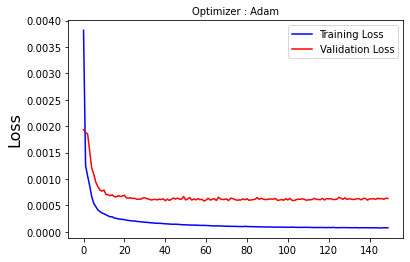

In [312]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')